In [3]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

import shannon

# import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
constants = np.load(os.path.expanduser('~/data/surround/2017_10_9_diversity_constants.npy')).item()
signal = np.array(np.load(os.path.expanduser('~/data/surround/signal_3_23.npy')))

In [9]:
len(constants['space'])

399

In [10]:
50 * constants['spacing']

1.0869565217391304

In [3]:
constants.keys()

dict_keys(['microns_per_degree', 'pixelsToDeg', 'photoreceptor_width', 'retina_width', 'frequency_spacing', 'highest_frequency', 'receptive_fields', 'N', 'freqs', 'space', 'spacing', 'contrast', 'center_widths', 'surround_widths', 'center_strengths', 'surround_strengths', 'fit_failures', 'median_center_widths', 'horz_pf', 'ama_pf', 'target_power', 'resolution', 'info_maps', 'failures', 'detailed_failures', 'celltype', 'center', 'input_noise', 'output_noise', 'target_snr'])

# Information analysis  
  
  Still some aspects of this analysis are counter-intuitive. For instance, the horizontal weight should presumably be much lower for such a high SNR. And why don't we see diverse horizontal weights? Let's move to an analysis where we specifically compute the mutual information.

In [4]:
def rf_model(horz_weight, center_weight):
    return center_weight*constants['center'] + (1-center_weight)*(
        horz_weight*constants['horz_pf'] + (1-horz_weight)*constants['ama_pf'])

In [5]:
def generate_spatial_signals(batch_size, signal=signal):
    # We generate white noise sequences, then multiply their frequency spectra
    # by the signal frequency spectra to make it look like a natural sequence.
    random_seq = [np.random.randn(2 * len(signal) - 1) for b in range(batch_size)]
    spatial_seq = [np.fft.irfft(np.fft.rfft(s) * signal) for s in random_seq]
    return np.stack(spatial_seq)

In [6]:
blah = generate_spatial_signals(10000)

In [7]:
blah.shape

(10000, 398)

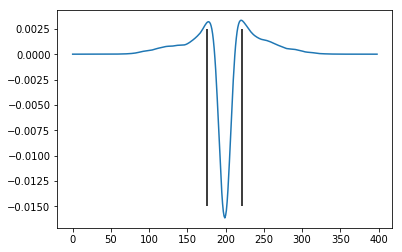

In [8]:
plt.plot(rf_model(0.5, 0.5))
plt.vlines(176, -0.015, 0.0025)
plt.vlines(222, -0.015, 0.0025)

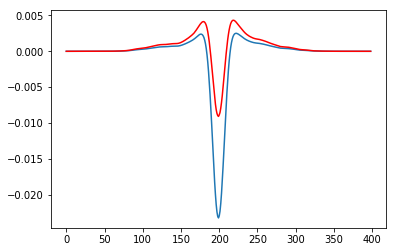

In [519]:
plt.plot(rf_model(0.5, 0.6))
plt.plot(rf_model(0.5, 0.4), 'r')

In [9]:
t = scipy.linalg.toeplitz(np.zeros(400), r=rf_model(0.5, 0.5))
t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_model(0.5, 0.5)[::-1])
t2 = t_rev[::-1, ::-1]

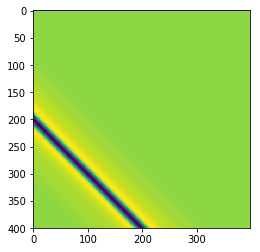

In [10]:
plt.imshow(t2)

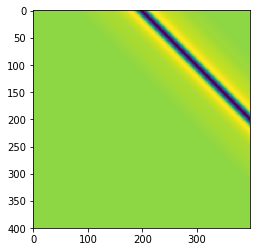

In [11]:
plt.imshow(t)

In [12]:
filters = np.vstack([t2, t])[200:-200]

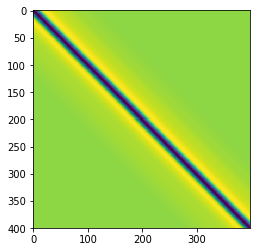

In [13]:
plt.imshow(filters)

In [14]:
filters_sparse = filters[25:-25:50]

In [15]:
filters_sparse.shape

(7, 399)

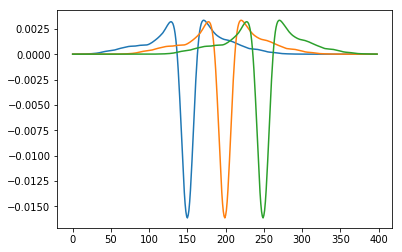

In [16]:
plt.plot(filters[150])
plt.plot(filters[200])
plt.plot(filters[250])

In [17]:
sigma_f = np.cov(filters_sparse)

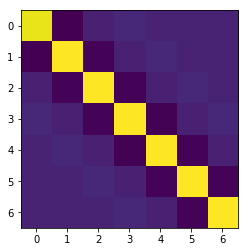

In [18]:
plt.imshow(sigma_f)

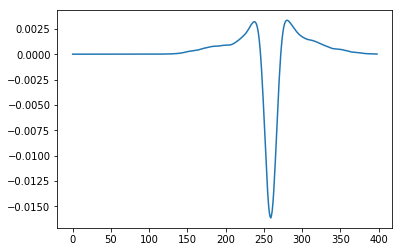

In [19]:
plt.plot(t[60])

In [20]:
def filter_bank(hws, cws):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = rf_model(hw, cw)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [21]:
f = filter_bank([0.2, 0.5], [0.6, 0.5])

In [22]:
f.shape

(14, 399)

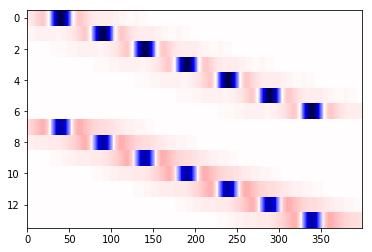

In [512]:
plt.imshow(f, aspect='auto', clim=[-np.max(abs(f)), np.max(abs(f))], cmap='seismic')

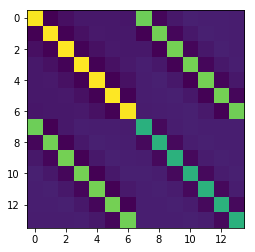

In [24]:
plt.imshow(np.cov(f))

In [25]:
f.shape

(14, 399)

In [26]:
spatial_signals = generate_spatial_signals(1000)
spatial_signals.shape

(1000, 398)

In [27]:
np.cov(np.dot(f[:, :-1], spatial_signals.T)).shape

(14, 14)

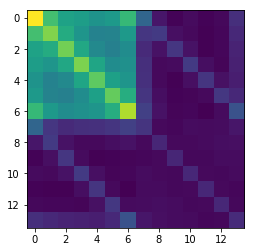

In [28]:
plt.imshow(np.cov(np.dot(f[:, :-1], spatial_signals.T)))

In [29]:
sigma_s = np.cov(np.dot(f[:, :-1], spatial_signals.T))
sigma_n = np.cov(f)

In [30]:
sigma_t = sigma_s + sigma_n

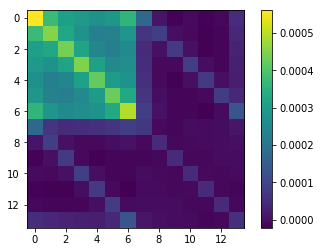

In [31]:
plt.imshow(sigma_t)
plt.colorbar()

In [32]:
chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(sigma_t))))
chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(sigma_n))))

In [33]:
chol_t

-77.255990165548624

In [34]:
chol_n

-96.296504612616431

In [35]:
chol_t - chol_n

19.040514447067807

In [37]:
def mutual_information(hws, cws, samples=1000, target_snr=7.5, input_noise=0.1, output_noise=0.3):
    '''Mutual information between a spatial signal and the output of a bank of filters.
    
    Args:
        hws: horizontal weightings for the filter bank.
        cws: center weightings for the filter bank.
        samples: number of observations to generate.
        target_snr: signal-to-noise ratio to constrain the filter banks.
    Returns:
        info: Mutual information between x and y in nats.
    '''
    spatial_signals = generate_spatial_signals(samples)
    filters = filter_bank(hws, cws)
    sigma_f = np.cov(filters)
    sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
    
    def sigmas(filter_constants, return_snr=False):
        ff_const = np.outer(filter_constants, filter_constants)
        sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2
        sigma_signal = ff_const * sigma_s
        sigma_t = sigma_signal + sigma_n
        
        signal_var = np.diag(sigma_signal)
        noise_var = np.diag(sigma_n)
        snr = signal_var/noise_var
        if return_snr:
            return snr
        else:
            return sigma_t, sigma_n
        
    def mse(filter_constants):
        snr = sigmas(filter_constants, return_snr=True)
        return np.mean((snr - target_snr)**2)
    
    res = scipy.optimize.minimize(mse, np.random.rand(sigma_f.shape[0], 1))
    opt_filter_const = res.x
    
    sigma_t, sigma_n = sigmas(opt_filter_const)
    chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
    chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
    return 0.5 * (chol_t - chol_n)

In [441]:
input_noise

0.0469253741641

In [440]:
output_noise

0.35

In [38]:
mi = mutual_information([0.5], [1.0])

In [39]:
mi

11.373148945154858

In [40]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        hws = [hw]
        cws = [cw]
        samples = 1000
        target_snr = 10.5
        input_noise = 0.1
        output_noise = 0.35
        spatial_signals = generate_spatial_signals(samples)
        filters = filter_bank(hws, cws)
        sigma_f = np.cov(filters)
        sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))

        def sigmas(filter_constants, return_snr=False):
            ff_const = np.outer(filter_constants, filter_constants)
            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_snr:
                return snr
            else:
                return sigma_t, sigma_n

        def mse(filter_constants):
            snr = sigmas(filter_constants, return_snr=True)
            return np.mean((snr - target_snr)**2)

        res = scipy.optimize.minimize(mse, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = res.x

        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi

20it [01:29,  4.45s/it]


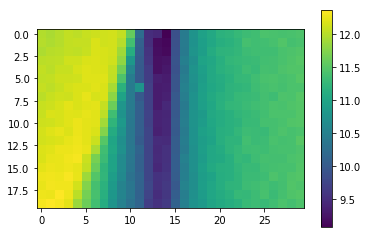

In [41]:
plt.imshow(info_map[:20, :30])
plt.colorbar()

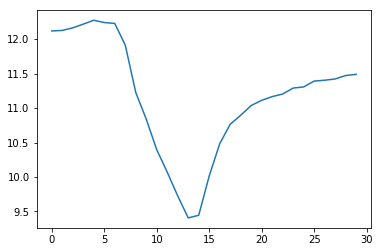

In [42]:
plt.plot(info_map[:20, :30][10])

In [43]:
input_noise = 0.0469253741641 #0.098762200628786892
output_noise = 0.35
# target_power = 48.053365503112332 #54.131410989171826
target_power = 100.
target_snr = 0.5

In [44]:
old_info_map = info_map

In [45]:
def filter_bank(hws, cws):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = rf_model(hw, cw)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [46]:
opt_filter_const.shape

(7,)

In [47]:
filters.shape

(7, 399)

In [48]:
(filters.T * opt_filter_const).T

array([[ -1.03183785e-06,  -1.99510319e-06,  -3.79375956e-06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -2.84245991e-30,  -1.26625611e-29,  -5.54752532e-29, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -5.91504245e-72,  -6.07097396e-71,  -6.12786809e-70, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -2.99434477e-90,  -2.16028431e-91,  -1.53274728e-92],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -2.03866950e-42,  -3.38866966e-43,  -5.53939296e-44],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -1.06381445e-12,  -4.07400532e-13,  -1.53436199e-13]])

In [49]:
(np.dot((filters.T * opt_filter_const).T, (filters.T * opt_filter_const)))

array([[  5.80340079e+000,   1.71243325e-004,   4.40106560e-018,
          9.79697732e-041,   1.00303948e-071,   2.45967711e-112,
          5.33021443e-162],
       [  1.71243325e-004,   5.82609036e+000,   1.72644950e-004,
          4.43119248e-018,   3.44621499e-040,   9.74394697e-072,
          2.43463560e-112],
       [  4.40106560e-018,   1.72644950e-004,   5.89879112e+000,
          1.74567032e-004,   1.03128762e-017,   3.36205508e-040,
          9.68581913e-072],
       [  9.79697732e-041,   4.43119248e-018,   1.74567032e-004,
          5.95653794e+000,   2.67305143e-004,   1.00476572e-017,
          3.33755794e-040],
       [  1.00303948e-071,   3.44621499e-040,   1.03128762e-017,
          2.67305143e-004,   6.05347321e+000,   1.72845447e-004,
          4.36131821e-018],
       [  2.45967711e-112,   9.74394697e-072,   3.36205508e-040,
          1.00476572e-017,   1.72845447e-004,   5.69041235e+000,
          1.65552614e-004],
       [  5.33021443e-162,   2.43463560e-112,   9.68

In [50]:
residual = (np.outer(opt_filter_const, opt_filter_const) * np.dot(filters, filters.T)) - (
    np.dot((filters.T * opt_filter_const).T, (filters.T * opt_filter_const)))

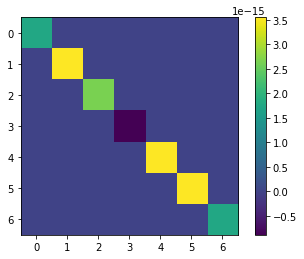

In [51]:
plt.imshow(residual)
plt.colorbar()

In [52]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
samples = 1000
spatial_signals = generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        hws = [hw]
        cws = [cw]
        filters = filter_bank(hws, cws)
#         sigma_f = np.cov(filters)
#         sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            normed_filters = (filters.T * filter_constants).T
            sigma_f = np.dot(normed_filters, normed_filters.T)
            fs = np.dot(normed_filters[:, :-1], spatial_signals.T)
            sigma_s = np.dot(fs, fs.T)
            sigma_n = input_noise**2 * sigma_f + output_noise**2
            sigma_signal = sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_snr, 10.9 * np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)

        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi

20it [07:22, 22.15s/it]


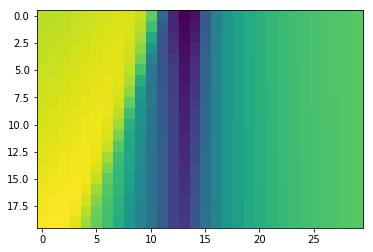

In [53]:
plt.imshow(info_map)

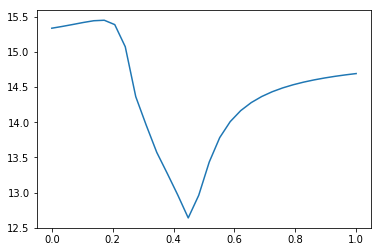

In [54]:
plt.plot(all_cws, info_map[10])

In [55]:
opt_filter_const

array([ 0.08358996,  0.08093414,  0.08111791,  0.08198729,  0.08270494,
        0.08474178,  0.08503527])

In [56]:
filters.shape

(7, 399)

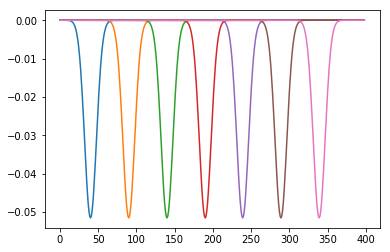

In [57]:
plt.plot(filters.T);

In [58]:
chol_t

-3.9938290392245546

In [59]:
chol_n

-33.378585938196906

In [60]:
input_noise = 0.0469253741641 #0.098762200628786892
output_noise = 0.35
target_power = 48.053365503112332 #54.131410989171826
# target_power = 100.
# target_snr = 0.5

In [61]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
snr_map = np.zeros((20, 30))
spatial_signals = 10. * generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
#         sigma_f = np.cov(filters)
#         sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            ff_const = np.outer(filter_constants, filter_constants)
            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)
        
        snr = sigmas(opt_filter_const, return_flag='snr')
        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi
        snr_map[idh, idc] = np.mean(snr)

20it [00:20,  1.00it/s]


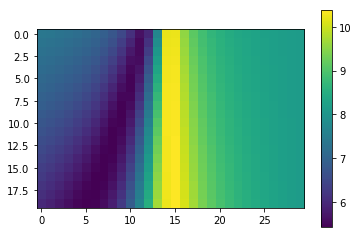

In [62]:
plt.imshow(info_map)
plt.colorbar()

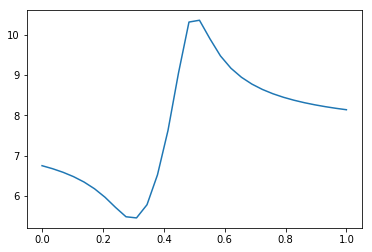

In [63]:
plt.plot(all_cws, info_map[10])

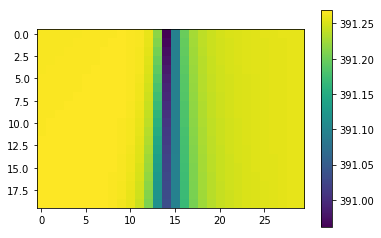

In [64]:
plt.imshow(snr_map)
plt.colorbar()

In [65]:
filters = filter_bank([0.5], [0.7])

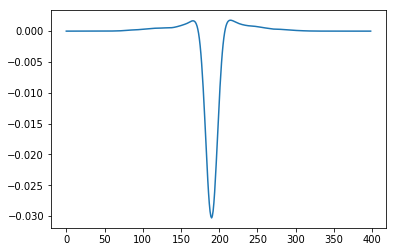

In [66]:
plt.plot(filters[3])

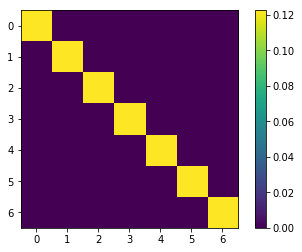

In [67]:
plt.imshow(sigma_n)
plt.colorbar()

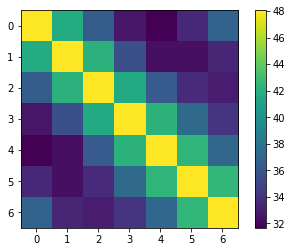

In [68]:
plt.imshow(sigma_t)
plt.colorbar()

In [69]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
snr_map = np.zeros((20, 30))
spatial_signals = 10. * generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
#         sigma_f = np.cov(filters)
#         sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            ff_const = np.outer(filter_constants, filter_constants)
#             sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            nn = input_noise**2 * np.eye(filters.shape[-1])
            fn = np.dot(np.dot(filters, nn), filters.T)
            sigma_n = fn + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)
        
        snr = sigmas(opt_filter_const, return_flag='snr')
        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi
        snr_map[idh, idc] = np.mean(snr)

20it [02:18,  7.16s/it]


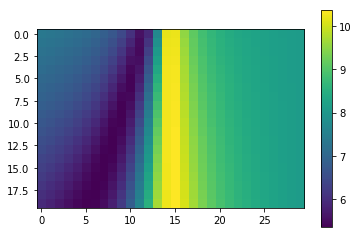

In [70]:
plt.imshow(info_map)
plt.colorbar()

# Okay we've settled on the following:

In [71]:
def filter_bank(hws, cws):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = rf_model(hw, cw)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [72]:
input_noise = 0.0469253741641 #0.098762200628786892
output_noise = 0.35
target_power = 48.053365503112332 #54.131410989171826
# target_power = 100.
# target_snr = 0.5

In [145]:
hw_res = 60
cw_res = 80
all_hws = np.linspace(0, 1, hw_res)
all_cws = np.linspace(0, 1, cw_res)
info_map = np.zeros((hw_res, cw_res))
spatial_signals = generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            ff_const = np.outer(filter_constants, filter_constants)
            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)
        
        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi

60it [01:40,  1.67s/it]


(0, 1)

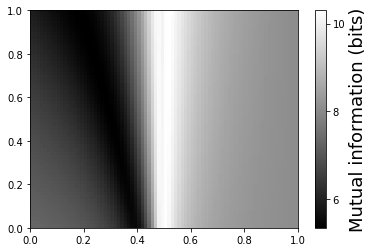

In [74]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

In [75]:
np.unravel_index(np.argmax(info_map), (60, 80))

(59, 41)

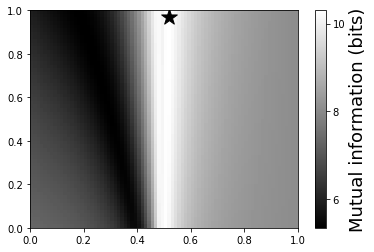

In [76]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])
plt.scatter(all_cws[41], all_hws[59] - 0.03, color='k', s=270, marker='*')

In [77]:
info_map.shape

(60, 80)

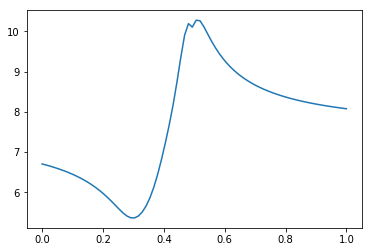

In [78]:
plt.plot(all_cws, info_map[30])

In [142]:
hw_res = 20
cw_res = 30
all_hws = np.linspace(0, 1, hw_res)
all_cws = np.linspace(0, 1, cw_res)
info_map = np.zeros((hw_res, cw_res))
spatial_signals = generate_spatial_signals(samples)
num_repeat = 7
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
#             ff_types = np.outer(filter_constants, filter_constants)
#             ff_const = np.repeat(
#                 np.repeat(ff_types, [num_repeat, num_repeat], axis=0),
#                 [num_repeat, num_repeat], axis=-1)
            ff_types = filter_constants**2
            ff_const = np.ones((7, 7)) * ff_types

            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            if return_flag == 'snr':
                signal_var = np.diag(sigma_signal)
                noise_var = np.diag(sigma_n)
                snr = signal_var/noise_var
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)

        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(1))
        opt_filter_const = abs(res.x)

        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi

20it [00:02,  8.56it/s]


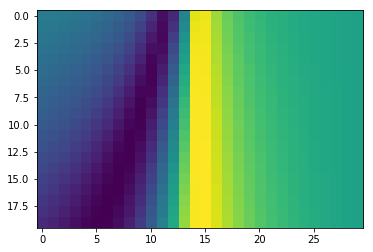

In [143]:
plt.imshow(info_map)

# Now for multiple dimensions

In [81]:
# hw_res = 6
# cw_res = 8
# all_hws = np.linspace(0, 1, hw_res)
# all_cws = np.linspace(0, 1, cw_res)
# info_map = np.zeros((hw_res, cw_res, hw_res, cw_res))
# spatial_signals = generate_spatial_signals(samples)
# num_repeat = 7
# for idh, hw in tqdm(enumerate(all_hws)):
#     for idc, cw in enumerate(all_cws):
#         for idh2, hw2 in enumerate(all_hws):
#             for idc2, cw2 in enumerate(all_cws):
#                 filters = filter_bank([hw, hw2], [cw, cw2])
#                 sigma_f = np.dot(filters, filters.T)
#                 fs = np.dot(filters[:, :-1], spatial_signals.T)
#                 sigma_s = np.dot(fs, fs.T)

#                 def sigmas(filter_constants, return_flag='sigmas'):
#                     ff_types = np.outer(filter_constants, filter_constants)
#                     ff_const = np.repeat(
#                         np.repeat(ff_types, [num_repeat, num_repeat], axis=0),
#                         [num_repeat, num_repeat], axis=-1)
                    
#                     sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
#                     sigma_signal = ff_const * sigma_s
#                     sigma_t = sigma_signal + sigma_n

#                     if return_flag == 'snr':
#                         signal_var = np.diag(sigma_signal)
#                         noise_var = np.diag(sigma_n)
#                         snr = signal_var/noise_var
#                         return snr
#                     elif return_flag == 'sigmas':
#                         return sigma_t, sigma_n
#                     elif return_flag == 'power':
#                         return np.diag(sigma_t)

#                 def mse_snr(filter_constants):
#                     snr = sigmas(filter_constants, return_flag='snr')
#                     return np.mean((snr - target_snr)**2)

#                 def mse_power(filter_constants):
#                     power = sigmas(filter_constants, return_flag='power')
#                     return np.mean((power - target_power)**2)

#                 res = scipy.optimize.minimize(mse_power, np.random.rand(2, 1))
#                 opt_filter_const = abs(res.x)

#                 sigma_t, sigma_n = sigmas(opt_filter_const)
#                 chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
#                 chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
#                 mi =  0.5 * (chol_t - chol_n)
#                 info_map[idh, idc, idh2, idc2] = mi

6it [00:22,  3.66s/it]


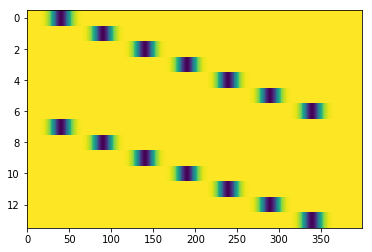

In [82]:
plt.imshow(filters, aspect='auto')

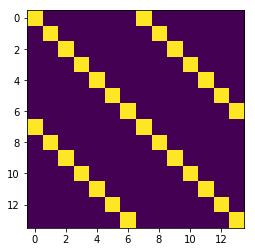

In [83]:
plt.imshow(sigma_f)

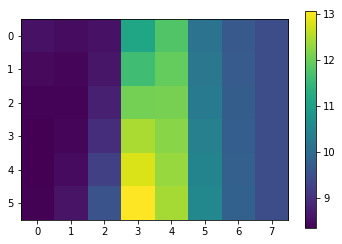

In [84]:
plt.imshow(info_map[:, :, 0, 0])
plt.colorbar()

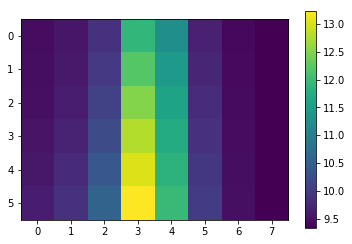

In [85]:
plt.imshow(info_map[:, :, -1, -1])
plt.colorbar()

In [86]:
np.unravel_index(np.argmax(info_map), [6, 8, 6, 8])

(5, 4, 5, 3)

In [87]:
all_hws

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [88]:
all_cws

array([ 0.        ,  0.14285714,  0.28571429,  0.42857143,  0.57142857,
        0.71428571,  0.85714286,  1.        ])

In [89]:
info_map[5, 4, 5, 3]

14.016940549319745

In [90]:
info_map[5, 4, 0, 3]

13.950726419009527

# Optimization for multiple dimensions

In [91]:
samples = 1000
spatial_signals = generate_spatial_signals(samples)
num_repeat = 7

def neg_mutual_information(weights):
    num_filters = len(weights)//2
    hws = weights[:num_filters]
    cws = weights[num_filters:]
    filters = filter_bank(hws, cws)
    sigma_f = np.dot(filters, filters.T)
    fs = np.dot(filters[:, :-1], spatial_signals.T)
    sigma_s = np.dot(fs, fs.T)

    def sigmas(filter_constants, return_flag='sigmas'):
        if len(filter_constants) == 1:
            ff_types = filter_constants**2
            ff_const = np.ones((num_repeat, num_repeat)) * ff_types
        else:
            ff_types = np.outer(filter_constants, filter_constants)
            ff_const = np.repeat(
                np.repeat(ff_types, num_filters * [num_repeat], axis=0),
                num_filters * [num_repeat], axis=-1)

        sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
        sigma_signal = ff_const * sigma_s
        sigma_t = sigma_signal + sigma_n

        if return_flag == 'snr':
            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            return snr
        elif return_flag == 'sigmas':
            return sigma_t, sigma_n
        elif return_flag == 'power':
            return np.diag(sigma_t)

    def mse_snr(filter_constants):
        snr = sigmas(filter_constants, return_flag='snr')
        return np.mean((snr - target_snr)**2)

    def mse_power(filter_constants):
        power = sigmas(filter_constants, return_flag='power')
        return np.mean((power - target_power)**2)

    res = scipy.optimize.minimize(mse_power, np.random.rand(num_filters, 1))
    opt_filter_const = abs(res.x)

    sigma_t, sigma_n = sigmas(opt_filter_const)
    chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
    chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
    mi =  0.5 * (chol_t - chol_n)
    return -mi + 20

In [92]:
# res = scipy.optimize.minimize(neg_mutual_information, [0.6, 0.5], bounds=[[0,1], [0,1]])
# res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2), method='Nelder-Mead')
res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2), bounds=[[0,1], [0,1]])

In [93]:
res

      fun: 9.8126277932172705
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.80541591, -2.93991711])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 144
      nit: 8
   status: 0
  success: True
        x: array([ 0.31840191,  0.50964335])

In [94]:
-1 * (neg_mutual_information(res.x) - 12)

2.1873722054663052

In [95]:
-1 * (neg_mutual_information([0.95, 0.5135]) - 12)

2.1931311973307324

# Okay this is reasonable, now try multiple filters

In [96]:
num_filters = 2
res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                              bounds=[[0,1] for _ in range(2 * num_filters)])

In [97]:
res

      fun: 5.3792478479689176
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.08400169,  0.2022789 , -0.77703799, -0.65017733])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 115
      nit: 4
   status: 0
  success: True
        x: array([  7.76327967e-11,   1.00000000e+00,   1.39623869e-01,
         4.81113262e-01])

In [98]:
lowest_fun = 100
all_x = []
all_fun = []
iterations = 20
num_filters = 2
for i in tqdm(range(iterations)):
    res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                  bounds=[[0,1] for _ in range(2 * num_filters)])
    if res.fun < lowest_fun:
        lowest_fun = res.fun
        opt_x = res.x
    all_x.append(res.x)
    all_fun.append(res.fun)

100%|██████████| 20/20 [00:37<00:00,  1.98s/it]


In [99]:
lowest_fun

4.917110595018638

In [100]:
opt_x

array([ 0.49434889,  0.18865375,  0.54367416,  0.47714211])

In [101]:
all_x

[array([ 0.49434889,  0.18865375,  0.54367416,  0.47714211]),
 array([ 0.94465155,  0.94941924,  0.48890347,  0.31374935]),
 array([ 0.55205267,  0.06761234,  0.48010532,  0.66194479]),
 array([ 0.46700101,  0.90604777,  0.48224075,  0.73142875]),
 array([ 0.79276707,  0.25519661,  0.83770212,  0.48408051]),
 array([  7.02514537e-01,   1.13844206e-03,   4.83935380e-01,
          2.29502421e-05]),
 array([ 0.50830658,  0.51711419,  0.4916808 ,  0.35637992]),
 array([ 0.88444726,  0.88610074,  0.48816419,  0.31007191]),
 array([ 0.623236  ,  0.63716284,  0.62057802,  0.47763523]),
 array([  0.00000000e+00,   0.00000000e+00,   3.22419779e-15,
          0.00000000e+00]),
 array([ 0.,  0.,  0.,  0.]),
 array([ 0.54116749,  0.47360951,  0.50824641,  0.44525183]),
 array([ 0.38223618,  0.72054796,  0.46929007,  0.52407368]),
 array([ 0.33873635,  0.87123976,  0.4827366 ,  0.69324675]),
 array([ 0.33491036,  0.05042191,  0.48403944,  0.77396649]),
 array([ 0.81674513,  0.08835721,  0.47086616,

In [102]:
optimal_filters = []
optimal_fun = []
for num_filters in tqdm(range(1, 11)):
    lowest_fun = 100
    all_x = []
    all_fun = []
    iterations = 20
    for i in range(iterations):
        res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                      bounds=[[0,1] for _ in range(2 * num_filters)])
        if res.fun < lowest_fun:
            lowest_fun = res.fun
            opt_x = res.x
        all_x.append(res.x)
        all_fun.append(res.fun)
    optimal_filters.append(opt_x)
    optimal_fun.append(-(lowest_fun - 20))

100%|██████████| 10/10 [3:03:12<00:00, 1938.51s/it]


In [103]:
samples = 1000
spatial_signals = generate_spatial_signals(samples)
num_repeat = 7
target_power = 48.

def mutual_information(weights):
    num_filters = len(weights)//2
    hws = weights[:num_filters]
    cws = weights[num_filters:]
    filters = filter_bank(hws, cws)
    sigma_f = np.dot(filters, filters.T)
    fs = np.dot(filters[:, :-1], spatial_signals.T)
    sigma_s = np.dot(fs, fs.T)

    def sigmas(filter_constants, return_flag='sigmas'):
        if len(filter_constants) == 1:
            ff_types = filter_constants**2
            ff_const = np.ones((num_repeat, num_repeat)) * ff_types
        else:
            ff_types = np.outer(filter_constants, filter_constants)
            ff_const = np.repeat(
                np.repeat(ff_types, [num_repeat, num_repeat], axis=0),
                [num_repeat, num_repeat], axis=-1)

        sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
        sigma_signal = ff_const * sigma_s
        sigma_t = sigma_signal + sigma_n

        if return_flag == 'snr':
            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            return snr
        elif return_flag == 'sigmas':
            return sigma_t, sigma_n
        elif return_flag == 'power':
            return np.diag(sigma_t)

    def mse_snr(filter_constants):
        snr = sigmas(filter_constants, return_flag='snr')
        return np.mean((snr - target_snr)**2)

    def mse_power(filter_constants):
        power = sigmas(filter_constants, return_flag='power')
        return np.mean((power - target_power)**2)

    res = scipy.optimize.minimize(mse_power, np.random.rand(num_filters, 1))
    opt_filter_const = abs(res.x)

    sigma_t, sigma_n = sigmas(opt_filter_const)
    chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
    chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
    mi =  0.5 * (chol_t - chol_n)
    return mi

In [104]:
mutual_information([0, 1, 0.515, 0.515])

12.801398422769715

In [105]:
mutual_information([0.5, 0.5, 0.515, 0.515])

11.246958354218586

In [106]:
mutual_information([0, 0, 0.515, 0.515])

11.159540684974385

In [107]:
mutual_information([1, 1, 0.515, 0.515])

11.267952311363317

In [108]:
mutual_information([0, 0, 0.498, 0.6])

14.591610061817567

In [109]:
mutual_information([0, 1, 0.498, 0.6])

14.991684690085046

In [110]:
mutual_information([0, 0.515])

10.022757912688366

In [111]:
optimal_filters = []
optimal_fun = []
for num_filters in tqdm(range(1, 11)):
    lowest_fun = 100
    all_x = []
    all_fun = []
    iterations = 20
    for i in range(iterations):
        res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                      bounds=[[0,1] for _ in range(2 * num_filters)])
        if res.fun < lowest_fun:
            lowest_fun = res.fun
            opt_x = res.x
        all_x.append(res.x)
        all_fun.append(res.fun)
    optimal_filters.append(opt_x)
    optimal_fun.append(-(lowest_fun - 20))

100%|██████████| 10/10 [3:09:40<00:00, 2301.53s/it]


In [112]:
optimal_fun

[10.168003376189731,
 15.32972866275718,
 17.386958025030111,
 18.217522477843417,
 18.683606032578332,
 18.976882602663188,
 19.751993674151162,
 19.496377953835136,
 20.289662095930211,
 20.802439491165394]

In [113]:
optimal_filters

[array([ 0.11486578,  0.48830195]),
 array([ 0.16031339,  0.93400172,  0.47816065,  0.53293024]),
 array([ 0.72710267,  0.        ,  0.91150652,  0.96979141,  0.48632022,
         0.48371082]),
 array([ 0.73888824,  0.99977018,  0.        ,  0.76157998,  0.80896774,
         0.48177116,  0.48688941,  0.999825  ]),
 array([  4.61276445e-12,   9.00190801e-01,   4.54273971e-01,
          4.38416270e-01,   8.97547681e-01,   4.84486576e-01,
          4.79403609e-01,   6.88315794e-01,   5.07722561e-01,
          3.65645741e-01]),
 array([ 0.06381425,  0.80634158,  0.        ,  0.37122627,  0.71151602,
         0.33146457,  0.04488172,  0.48177608,  0.48783094,  0.08992104,
         0.59821613,  0.06444953]),
 array([ 0.06221088,  0.66845777,  0.61268069,  0.        ,  0.96296299,
         0.13714767,  0.17008466,  0.94181084,  0.48839097,  0.47907303,
         0.48609661,  0.47781669,  0.79369784,  0.94529326]),
 array([ 0.83670918,  0.54178935,  0.02496974,  0.43520096,  0.11251223,
       

In [114]:
optimal_hws = []
optimal_cws = []
for weights in optimal_filters:
    n = len(weights)//2
    optimal_hws.append(weights[:n])
    optimal_cws.append(weights[n:])

In [115]:
optimal_hws

[array([ 0.11486578]),
 array([ 0.16031339,  0.93400172]),
 array([ 0.72710267,  0.        ,  0.91150652]),
 array([ 0.73888824,  0.99977018,  0.        ,  0.76157998]),
 array([  4.61276445e-12,   9.00190801e-01,   4.54273971e-01,
          4.38416270e-01,   8.97547681e-01]),
 array([ 0.06381425,  0.80634158,  0.        ,  0.37122627,  0.71151602,
         0.33146457]),
 array([ 0.06221088,  0.66845777,  0.61268069,  0.        ,  0.96296299,
         0.13714767,  0.17008466]),
 array([ 0.83670918,  0.54178935,  0.02496974,  0.43520096,  0.11251223,
         0.19857784,  0.37542522,  0.41435648]),
 array([ 0.03381167,  0.62990805,  0.70270759,  0.01626195,  0.13866676,
         0.17644608,  0.44454244,  0.58629338,  0.7896756 ]),
 array([  5.97840903e-01,   7.78479208e-01,   7.61664097e-01,
          5.21355157e-05,   8.47101201e-02,   3.97971932e-01,
          5.71857446e-02,   3.56260793e-01,   8.79772970e-01,
          4.34060020e-01])]

In [116]:
optimal_cws

[array([ 0.48830195]),
 array([ 0.47816065,  0.53293024]),
 array([ 0.96979141,  0.48632022,  0.48371082]),
 array([ 0.80896774,  0.48177116,  0.48688941,  0.999825  ]),
 array([ 0.48448658,  0.47940361,  0.68831579,  0.50772256,  0.36564574]),
 array([ 0.04488172,  0.48177608,  0.48783094,  0.08992104,  0.59821613,
         0.06444953]),
 array([ 0.94181084,  0.48839097,  0.47907303,  0.48609661,  0.47781669,
         0.79369784,  0.94529326]),
 array([ 0.48544427,  0.01820406,  0.63711387,  0.14615943,  0.48376287,
         0.48914764,  0.07959956,  0.        ]),
 array([ 0.19329102,  0.83566568,  0.48237161,  0.48750533,  0.48352637,
         0.17900992,  0.28463876,  0.49119729,  0.74680323]),
 array([ 0.34165475,  0.48629358,  0.48052005,  0.48480647,  0.48475242,
         0.71375475,  0.75459103,  0.42979546,  0.89027279,  0.99918263])]

In [117]:
flattened_opt_hws = []
flattened_num_filters = []
for i, hws in enumerate(optimal_hws):
    for hw in hws:
        flattened_opt_hws.append(hw)
        flattened_num_filters.append(i+1)

In [118]:
flattened_opt_cws = []
flattened_num_filters = []
for i,cws in enumerate(optimal_cws):
    for cw in cws:
        flattened_opt_cws.append(cw)
        flattened_num_filters.append(i+1)

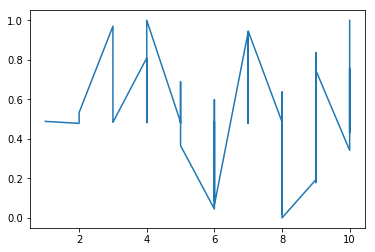

In [119]:
plt.plot(flattened_num_filters, flattened_opt_cws)

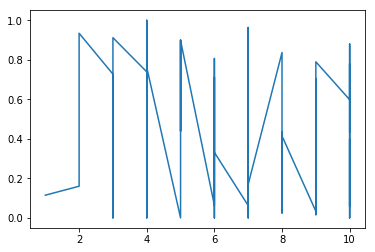

In [120]:
plt.plot(flattened_num_filters, flattened_opt_hws)

# For pretty diagrams, I'm going to sort hw and cw

In [121]:
sorted_optimal_cws = [sorted(cws) for cws in optimal_cws]
sorted_optimal_hws = [sorted(hws) for hws in optimal_hws]

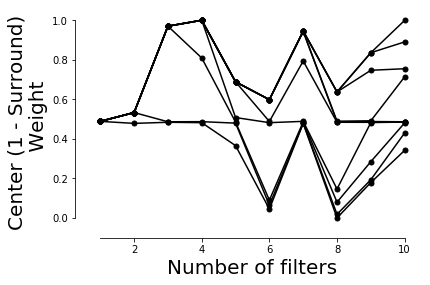

In [122]:
for depth in range(len(sorted_optimal_cws[-1])):
    this_series = []
    for num_filt in range(num_filters):
        index = np.min([len(sorted_optimal_cws[num_filt]) - 1, depth])
        this_series.append(sorted_optimal_cws[num_filt][index])
    plt.plot(np.arange(1, 11), this_series, 'k', marker='.', markersize=10)
plt.ylabel('Center (1 - Surround) \n Weight', fontsize=20)
plt.xlabel('Number of filters', fontsize=20)
adjust_spines(plt.gca())

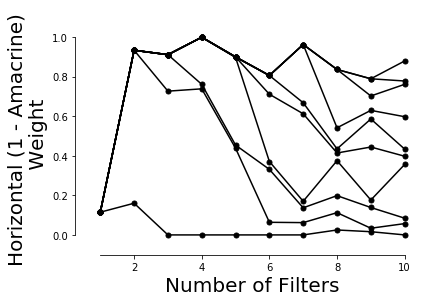

In [123]:
for depth in range(len(sorted_optimal_hws[-1])):
    this_series = []
    for num_filt in range(num_filters):
        index = np.min([len(sorted_optimal_hws[num_filt]) - 1, depth])
        this_series.append(sorted_optimal_hws[num_filt][index])
    plt.plot(np.arange(1, 11), this_series, 'k', marker='.', markersize=10)
plt.ylabel('Horizontal (1 - Amacrine) \n Weight', fontsize=20)
plt.xlabel('Number of Filters', fontsize=20)
adjust_spines(plt.gca())

In [124]:
multidimensional_info_map = info_map

In [128]:
info_map.shape

(6, 8, 6, 8)

In [129]:
# min_info = info_map.min()
# max_info = info_map.max()
# plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
#               aspect='auto', clim=[min_info, max_info])
# cbar = plt.colorbar()
# # cbar.set_ticks([6,7,8,9])
# cbar.set_ticks([6, 8, 10, 12])
# # plt.clim(0,np.max(info_color_map))
# cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
# plt.ylim([0,1])
# plt.scatter(all_cws[41], all_hws[59] - 0.03, color='k', s=270, marker='*')

In [130]:
# min_info = info_map.min()
# max_info = info_map.max()
# plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
#               aspect='auto', clim=[min_info, max_info])
# cbar = plt.colorbar()
# # cbar.set_ticks([6,7,8,9])
# cbar.set_ticks([6, 8, 10, 12])
# # plt.clim(0,np.max(info_color_map))
# cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
# plt.ylim([0,1])
# plt.scatter(all_cws[41], all_hws[59] - 0.03, color='k', s=270, marker='*')
# plt.scatter(optimal_cws[0], optimal_hws[0], color='r')
# plt.scatter(optimal_cws[1], optimal_hws[1], color='orange')
# # plt.scatter(optimal_cws[2], optimal_hws[2], color='green')
# # plt.scatter(optimal_cws[3], optimal_hws[3], color='cyan')
# # plt.scatter(optimal_cws[4], optimal_hws[4], color='blue')
# # plt.scatter(optimal_cws[5], optimal_hws[5], color='magenta')

In [132]:
# min_info = info_map.min()
# max_info = info_map.max()
# plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
#               aspect='auto', clim=[min_info, max_info])
# cbar = plt.colorbar()
# # cbar.set_ticks([6,7,8,9])
# cbar.set_ticks([6, 8, 10, 12])
# # plt.clim(0,np.max(info_color_map))
# cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
# plt.ylim([0,1])
# plt.scatter(all_cws[41], all_hws[59] - 0.03, color='k', s=270, marker='*')
# plt.scatter(optimal_cws[0], optimal_hws[0], color='r')
# plt.scatter(optimal_cws[1], optimal_hws[1], color='orange')
# plt.scatter(optimal_cws[2], optimal_hws[2], color='green')
# plt.scatter(optimal_cws[3], optimal_hws[3], color='cyan')
# plt.scatter(optimal_cws[4], optimal_hws[4], color='blue')
# plt.scatter(optimal_cws[5], optimal_hws[5], color='magenta')

In [133]:
# plt.plot(np.arange(1,11), optimal_fun, 'k', linewidth=3, marker='.', markersize=15)
# plt.xlabel('Number of filters', fontsize=20)
# plt.ylabel('Mutual information (bits)', fontsize=20)
# adjust_spines(plt.gca())

# Run for even longer

In [134]:
optimal_filters_backup = optimal_filters
optimal_fun_backup = optimal_fun
all_x_backup = all_x
all_fun_backup = all_fun

In [ ]:
optimal_filters = []
optimal_fun = []
for num_filters in tqdm(range(1, 11)):
    lowest_fun = 100
    all_x = []
    all_fun = []
    iterations = 100
    for i in range(iterations):
        res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                      bounds=[[0,1] for _ in range(2 * num_filters)])
        if res.fun < lowest_fun:
            lowest_fun = res.fun
            opt_x = res.x
        all_x.append(res.x)
        all_fun.append(res.fun)
    optimal_filters.append(opt_x)
    optimal_fun.append(-(lowest_fun - 20))

 80%|████████  | 8/10 [7:42:19<3:14:41, 5840.64s/it]

In [136]:
optimal_filters

[array([ 0.16691431,  0.48768429]),
 array([ 0.05388557,  0.7918228 ,  0.48047914,  0.52766072]),
 array([ 0.04999207,  0.81835963,  0.99279593,  0.48259001,  0.63084159,
         0.48388676]),
 array([ 1.        ,  0.60592813,  0.        ,  0.78020305,  0.48033497,
         0.81253188,  0.48666206,  0.84645123]),
 array([ 0.80468043,  0.        ,  0.67385508,  1.        ,  0.9200748 ,
         0.67083783,  0.486642  ,  0.18847563,  0.48987377,  0.47907291]),
 array([ 0.66765537,  0.        ,  0.95817368,  0.9885996 ,  0.02579588,
         0.83033091,  0.08831075,  0.48751859,  0.4814767 ,  0.478986  ,
         0.20617672,  0.69614783]),
 array([  2.41399206e-01,   7.72958482e-01,   2.07082650e-03,
          9.94048988e-01,   8.06804578e-12,   7.99612145e-01,
          8.06670752e-01,   7.59960971e-01,   9.66439204e-01,
          4.80525050e-01,   4.78642654e-01,   4.87279634e-01,
          9.14719181e-01,   6.16273226e-01]),
 array([  8.07456298e-01,   8.72579255e-01,   9.10915141e-01

In [137]:
optimal_hws_backup = optimal_hws
optimal_cws_backup = optimal_cws

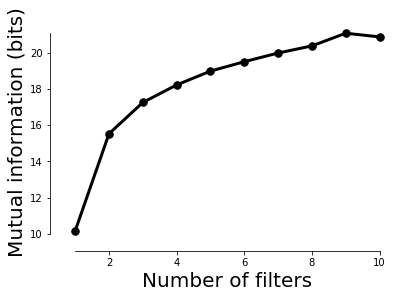

In [138]:
plt.plot(np.arange(1,11), optimal_fun, 'k', linewidth=3, marker='.', markersize=15)
plt.xlabel('Number of filters', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
adjust_spines(plt.gca())

In [146]:
optimal_hws = []
optimal_cws = []
for weights in optimal_filters:
    n = len(weights)//2
    optimal_hws.append(weights[:n])
    optimal_cws.append(weights[n:])

In [147]:
sorted_optimal_cws = [sorted(cws) for cws in optimal_cws]
sorted_optimal_hws = [sorted(hws) for hws in optimal_hws]

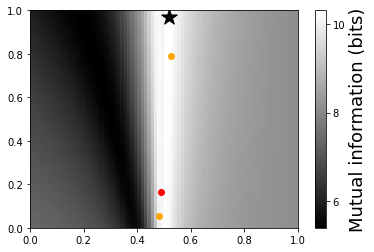

In [148]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])
plt.scatter(all_cws[41], all_hws[59] - 0.03, color='k', s=270, marker='*')
plt.scatter(optimal_cws[0], optimal_hws[0], color='r')
plt.scatter(optimal_cws[1], optimal_hws[1], color='orange')
# plt.scatter(optimal_cws[2], optimal_hws[2], color='green')
# plt.scatter(optimal_cws[3], optimal_hws[3], color='cyan')
# plt.scatter(optimal_cws[4], optimal_hws[4], color='blue')
# plt.scatter(optimal_cws[5], optimal_hws[5], color='magenta')

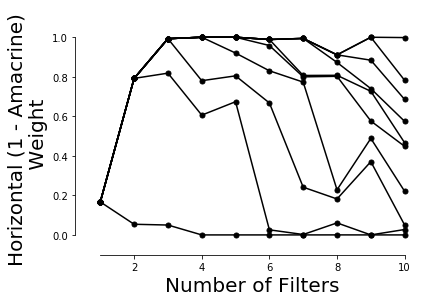

In [149]:
for depth in range(len(sorted_optimal_hws[-1])):
    this_series = []
    for num_filt in range(num_filters):
        index = np.min([len(sorted_optimal_hws[num_filt]) - 1, depth])
        this_series.append(sorted_optimal_hws[num_filt][index])
    plt.plot(np.arange(1, 11), this_series, 'k', marker='.', markersize=10)
plt.ylabel('Horizontal (1 - Amacrine) \n Weight', fontsize=20)
plt.xlabel('Number of Filters', fontsize=20)
adjust_spines(plt.gca())

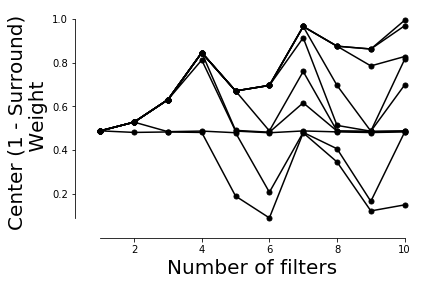

In [150]:
for depth in range(len(sorted_optimal_cws[-1])):
    this_series = []
    for num_filt in range(num_filters):
        index = np.min([len(sorted_optimal_cws[num_filt]) - 1, depth])
        this_series.append(sorted_optimal_cws[num_filt][index])
    plt.plot(np.arange(1, 11), this_series, 'k', marker='.', markersize=10)
plt.ylabel('Center (1 - Surround) \n Weight', fontsize=20)
plt.xlabel('Number of filters', fontsize=20)
adjust_spines(plt.gca())

# Addressing Steve's comments

In [151]:
optimal_hws_backup

[array([ 0.11486578]),
 array([ 0.16031339,  0.93400172]),
 array([ 0.72710267,  0.        ,  0.91150652]),
 array([ 0.73888824,  0.99977018,  0.        ,  0.76157998]),
 array([  4.61276445e-12,   9.00190801e-01,   4.54273971e-01,
          4.38416270e-01,   8.97547681e-01]),
 array([ 0.06381425,  0.80634158,  0.        ,  0.37122627,  0.71151602,
         0.33146457]),
 array([ 0.06221088,  0.66845777,  0.61268069,  0.        ,  0.96296299,
         0.13714767,  0.17008466]),
 array([ 0.83670918,  0.54178935,  0.02496974,  0.43520096,  0.11251223,
         0.19857784,  0.37542522,  0.41435648]),
 array([ 0.03381167,  0.62990805,  0.70270759,  0.01626195,  0.13866676,
         0.17644608,  0.44454244,  0.58629338,  0.7896756 ]),
 array([  5.97840903e-01,   7.78479208e-01,   7.61664097e-01,
          5.21355157e-05,   8.47101201e-02,   3.97971932e-01,
          5.71857446e-02,   3.56260793e-01,   8.79772970e-01,
          4.34060020e-01])]

In [152]:
np.repeat(optimal_filters_backup[0], 3)

array([ 0.11486578,  0.11486578,  0.11486578,  0.48830195,  0.48830195,
        0.48830195])

In [153]:
mutual_information(optimal_filters_backup[0])

10.181221611775975

In [154]:
-1*(neg_mutual_information(optimal_filters_backup[0]) - 20)

10.181221604539827

In [155]:
single_optimal_fun = [-1*(neg_mutual_information(
    np.repeat(optimal_filters_backup[0], i)) - 20) for i in np.arange(1, 11)]

In [156]:
np.repeat(optimal_filters_backup[0][1], 2)

array([ 0.48830195,  0.48830195])

In [157]:
splitting_hws_fun = []
for i in np.arange(1, 11):
    these_cws = np.repeat(optimal_filters_backup[0][1], i)
    these_hws = np.linspace(0, 1, i)
    if i == 1:
        these_hws = 1.0
    weights = np.zeros((2 * i, ))
    weights[:i] = these_hws
    weights[i:] = these_cws
    splitting_hws_fun.append(-1 * (neg_mutual_information(weights) - 20))

In [158]:
splitting_cws_fun = []
for i in np.arange(1, 11):
    these_hws = np.repeat(optimal_filters_backup[0][0], i)
    these_cws = np.linspace(0, 1, i)
    if i == 1:
        these_cws = optimal_filters_backup[0][1]
    weights = np.zeros((2 * i, ))
    weights[:i] = these_hws
    weights[i:] = these_cws
    splitting_cws_fun.append(-1 * (neg_mutual_information(weights) - 20))

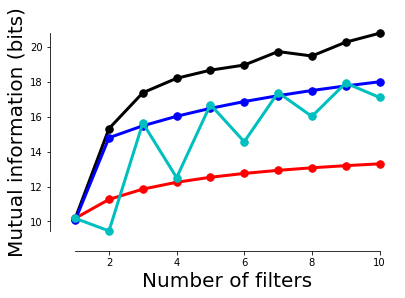

In [159]:
plt.plot(np.arange(1,11), optimal_fun_backup, 'k', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), single_optimal_fun, 'r', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), splitting_hws_fun, 'b', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), splitting_cws_fun, 'c', linewidth=3, marker='.', markersize=15)
plt.xlabel('Number of filters', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
adjust_spines(plt.gca())

# Single cell versus multi-cell information scatterplot

In [160]:
def mutual_information(weights):
    return -1. * (neg_mutual_information(weights) - 20)

In [161]:
def mean_single_cell_mi(weights):
    num_filters = len(weights)//2
    all_hws = weights[:num_filters]
    all_cws = weights[num_filters:]
    infos = []
    for f in range(num_filters):
        infos.append(mutual_information(np.array([all_hws[f], all_cws[f]])))
    return np.mean(infos)

In [162]:
single_cell_info = collections.defaultdict(list)
multi_cell_info = collections.defaultdict(list)
iterations = 1000
for num_filt in range(1, 11):
    for i in tqdm(range(iterations)):
        random_weights = np.random.rand(num_filt * 2)
        multi_cell_info[num_filt].append(mutual_information(random_weights))
        single_cell_info[num_filt].append(mean_single_cell_mi(random_weights))

100%|██████████| 1000/1000 [02:53<00:00,  5.67it/s]


In [163]:
single_cell_info.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [164]:
multi_cell_info.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

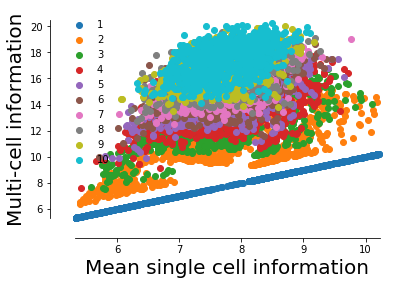

In [165]:
for i in range(1, 11):
    plt.scatter(single_cell_info[i], multi_cell_info[i], label=i)
# plt.scatter(single_cell_info[2], multi_cell_info[2], color='blue')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
adjust_spines(plt.gca())
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Mean single cell information', fontsize=20)
plt.ylabel('Multi-cell information', fontsize=20)

# Now plot our cells on this scatter plot

In [166]:
constants.keys()

dict_keys(['microns_per_degree', 'pixelsToDeg', 'photoreceptor_width', 'retina_width', 'frequency_spacing', 'highest_frequency', 'receptive_fields', 'N', 'freqs', 'space', 'spacing', 'contrast', 'center_widths', 'surround_widths', 'center_strengths', 'surround_strengths', 'fit_failures', 'median_center_widths', 'horz_pf', 'ama_pf', 'target_power', 'resolution', 'info_maps', 'failures', 'detailed_failures', 'celltype', 'center', 'input_noise', 'output_noise', 'target_snr'])

In [167]:
fits = np.load(expanduser('~/data/surround/fits_2017-05-20.npy')).item()

In [168]:
fits.keys()

dict_keys(['medium_off_adapting', 'fast_on', 'fast_off_sensitizing', 'fast_off_adapting', 'slow_off', 'ganglion'])

In [169]:
fits['medium_off_adapting'].shape

(159, 2)

In [170]:
np.random.choice(159, 2)

array([85, 72])

In [171]:
blah = fits['medium_off_adapting'][np.random.choice(159, 3)]

In [172]:
blah

array([[ 0.43493713,  0.56397548],
       [ 0.64471708,  0.55256356],
       [ 0.39981441,  0.5207745 ]])

In [173]:
blah.flatten(order='F')

array([ 0.43493713,  0.64471708,  0.39981441,  0.56397548,  0.55256356,
        0.5207745 ])

In [174]:
mutual_information(fits['medium_off_adapting'][np.random.choice(159)])

9.6306969375536031

In [175]:
mutual_information(blah.flatten(order='F'))

13.315022054210653

In [176]:
def random_sample_real_weights(num, celltype='medium_off_adapting'):
    max_cells = fits[celltype].shape[0]
    these_fits = fits[celltype][np.random.choice(max_cells, num)]
    return these_fits.flatten(order='F')

In [177]:
iterations = 1000
mean_data_info_vs_filters = []
sem_data_info_vs_filters = []
data_multicell_info = collections.defaultdict(list)
data_singlecell_info = collections.defaultdict(list)
for num_filt in range(1, 11):
    for i in tqdm(range(iterations)):
        these_weights = random_sample_real_weights(num_filt)
        data_singlecell_info[num_filt].append(mean_single_cell_mi(these_weights))
        data_multicell_info[num_filt].append(mutual_information(these_weights))
    mean_data_info_vs_filters.append(np.mean(data_multicell_info[num_filt]))
    sem_data_info_vs_filters.append(sem(data_multicell_info[num_filt]))

100%|██████████| 1000/1000 [02:48<00:00,  5.87it/s]


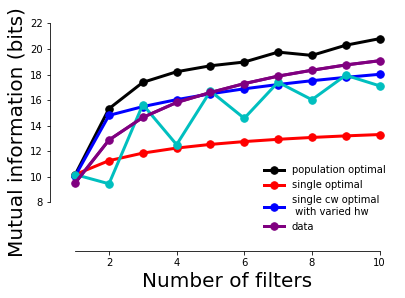

In [178]:
plt.plot(np.arange(1,11), optimal_fun_backup, 'k', linewidth=3, marker='.', markersize=15, label='population optimal')
plt.plot(np.arange(1,11), single_optimal_fun, 'r', linewidth=3, marker='.', markersize=15, label='single optimal')
plt.plot(np.arange(1,11), splitting_hws_fun, 'b', linewidth=3, marker='.', markersize=15, label='single cw optimal \n with varied hw')
plt.plot(np.arange(1,11), splitting_cws_fun, 'c', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), mean_data_info_vs_filters, linewidth=3, color='purple', marker='.', markersize=15, label='data')
plt.errorbar(np.arange(1,11), mean_data_info_vs_filters, yerr=sem_data_info_vs_filters, linewidth=3, color='purple')
plt.xlabel('Number of filters', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
plt.legend(loc='lower right', frameon=False)
plt.ylim(5, 22)
adjust_spines(plt.gca())

In [179]:
colors = plt.get_cmap('winter')(np.linspace(0, 1, 10))
data_colors = plt.get_cmap('gray')(np.linspace(0, 1, 10))[::-1]

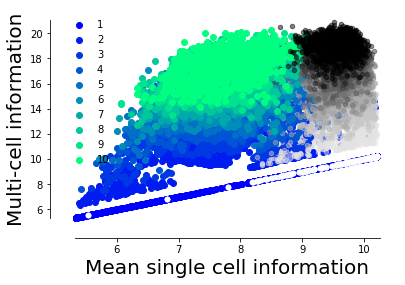

In [180]:
for i in range(1, 11):
    plt.scatter(single_cell_info[i], multi_cell_info[i], label=i, color=colors[i-1])
    plt.scatter(data_singlecell_info[i], data_multicell_info[i], color=data_colors[i-1], alpha=0.5, s=20)
# plt.scatter(single_cell_info[2], multi_cell_info[2], color='blue')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
adjust_spines(plt.gca())
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Mean single cell information', fontsize=20)
plt.ylabel('Multi-cell information', fontsize=20)

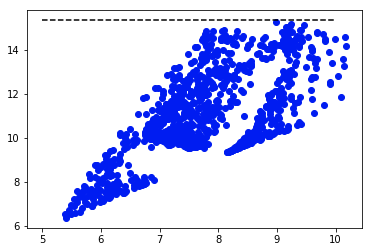

In [181]:
plt.scatter(single_cell_info[2], multi_cell_info[2], color=colors[1])
plt.plot(np.arange(5,11), 6*[optimal_fun_backup[1]], 'k--')

In [182]:
exhaustive_single_cell_info = []
exhaustive_multi_cell_info = []
iterations = 10000
num_filt = 2
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(num_filt * 2)
    exhaustive_multi_cell_info.append(mutual_information(random_weights))
    exhaustive_single_cell_info.append(mean_single_cell_mi(random_weights))

100%|██████████| 10000/10000 [02:56<00:00, 56.58it/s]


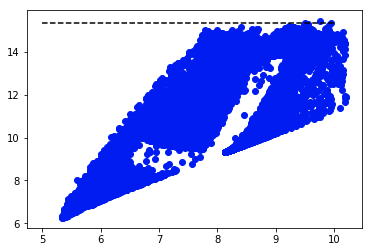

In [183]:
plt.scatter(exhaustive_single_cell_info, exhaustive_multi_cell_info, color=colors[1])
plt.plot(np.arange(5,11), 6*[optimal_fun_backup[1]], 'k--')

In [184]:
exhaustive_single_cell_info = []
exhaustive_multi_cell_info = []
iterations = 10000
num_filt = 3
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(num_filt * 2)
    exhaustive_multi_cell_info.append(mutual_information(random_weights))
    exhaustive_single_cell_info.append(mean_single_cell_mi(random_weights))

100%|██████████| 10000/10000 [06:43<00:00, 21.43it/s]


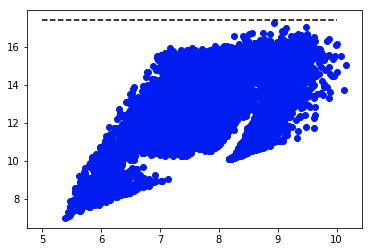

In [185]:
plt.scatter(exhaustive_single_cell_info, exhaustive_multi_cell_info, color=colors[1])
plt.plot(np.arange(5,11), 6*[optimal_fun_backup[2]], 'k--')

In [187]:
# for hw1 in tqdm(np.linspace(0, 1, 10)):
#     for cw1 in np.linspace(0, 1, 10):
#         for hw2 in np.linspace(0, 1, 10):
#             for cw2 in np.linspace(0, 1, 10):
                

In [188]:
optimal_cws[-1]

array([ 0.48263478,  0.96973882,  0.82858853,  0.4873349 ,  0.14815383,
        0.48191585,  0.48662291,  0.81573307,  0.99502532,  0.69826985])

In [189]:
optimal_weights = np.concatenate([optimal_hws[-1], optimal_cws[-1]])

In [190]:
mean_single_cell_mi(optimal_weights)

8.8814419565989109

In [191]:
mutual_information(optimal_weights)

20.983149772333995

(0, 1)

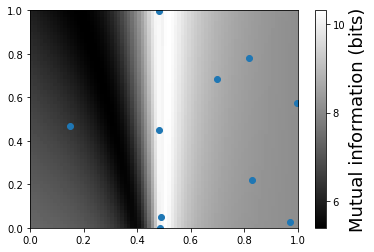

In [192]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

plt.scatter(optimal_cws[-1], optimal_hws[-1])
plt.xlim(0, 1)
plt.ylim(0, 1)

In [193]:
len(all_x)

100

In [194]:
len(all_fun)

100

<Container object of 20 artists>

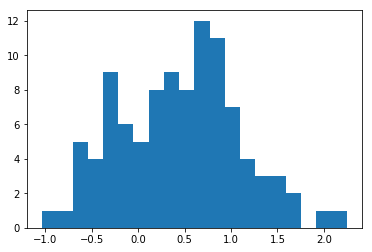

In [195]:
count, bins = np.histogram(all_fun, bins=20)
bin_width = np.mean(np.diff(bins))
plt.bar(bins[:-1] - bin_width/2, count, width=bin_width)

(0, 1)

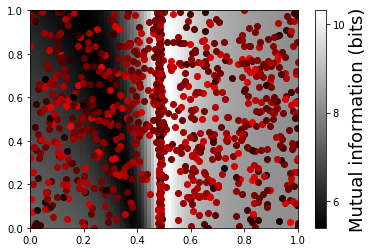

In [196]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

normalized_fun = all_fun - np.min(all_fun)
normalized_fun /= np.max(normalized_fun)
normalized_fun -= 1.0
normalized_fun *= -1.0
for idx, soln in enumerate(all_x):
    soln_cws = soln[10:]
    soln_hws = soln[:10]
#     plt.scatter(soln_cws, soln_hws, color='k', alpha=normalized_fun[idx])
    plt.scatter(soln_cws, soln_hws, color=[normalized_fun[idx], 0, 0])
    
plt.xlim(0, 1)
plt.ylim(0, 1)

In [197]:
np.argmax(all_fun)

37

In [198]:
soln_cws

array([ 0.16570257,  0.48251246,  0.48369834,  0.05784039,  0.70427235,
        0.78943633,  0.48505289,  0.34651852,  0.6045113 ,  0.6225674 ])

In [199]:
soln_hws

array([ 0.9865011 ,  0.2469247 ,  0.18664322,  0.16573899,  0.36907321,
        0.43317829,  0.93128317,  0.25474413,  0.32923282,  0.18419154])

In [200]:
optimal_fun

[10.168462045650426,
 15.527913085782622,
 17.253404503088866,
 18.220289607958932,
 18.983244652964707,
 19.501402208045636,
 19.982111474322487,
 20.374097400808303,
 21.072226697255147,
 20.871697555140436]

In [201]:
sorted_solns = np.argsort(all_fun)

In [202]:
sorted_solns[1]

6

(0, 1)

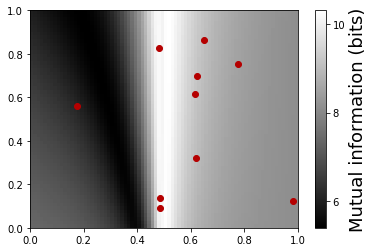

In [203]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

normalized_fun = all_fun - np.min(all_fun)
normalized_fun /= np.max(normalized_fun)
normalized_fun -= 1.0
normalized_fun *= -1.0
soln_cws = all_x[32][10:]
soln_hws = all_x[32][:10]
#     plt.scatter(soln_cws, soln_hws, color='k', alpha=normalized_fun[idx])
plt.scatter(soln_cws, soln_hws, color=[normalized_fun[idx], 0, 0])
    
plt.xlim(0, 1)
plt.ylim(0, 1)

(0, 1)

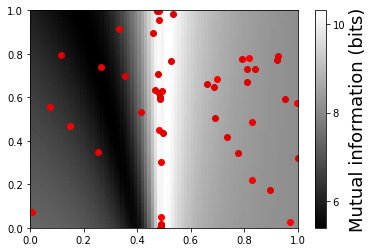

In [204]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

normalized_fun = all_fun - np.min(all_fun)
normalized_fun /= np.max(normalized_fun)
normalized_fun -= 1.0
normalized_fun *= -1.0
for idx in sorted_solns[:5]:
    soln_cws = all_x[idx][10:]
    soln_hws = all_x[idx][:10]
    #     plt.scatter(soln_cws, soln_hws, color='k', alpha=normalized_fun[idx])
    plt.scatter(soln_cws, soln_hws, color=[normalized_fun[idx], 0, 0])
    
plt.xlim(0, 1)
plt.ylim(0, 1)

In [205]:
hw_subpop = []
cw_subpop = []
for idx in sorted_solns[:5]:
    hw_subpop.append(all_x[idx][:10])
    cw_subpop.append(all_x[idx][10:])

<Container object of 20 artists>

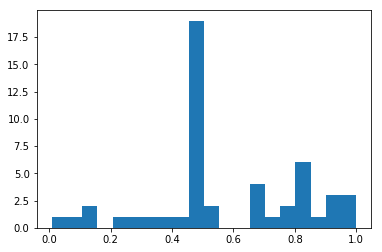

In [206]:
count, bins = np.histogram(cw_subpop, bins=20)
binwidth = np.mean(np.diff(bins))
plt.bar(bins[:-1] + binwidth/2.0, count, width=binwidth)

In [ ]:
optimal_filters = []
optimal_fun = []
for num_filters in tqdm(range(1, 11)):
    lowest_fun = 100
    all_x = []
    all_fun = []
    iterations = 100
    for i in range(iterations):
        res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                      bounds=[[0,1] for _ in range(2 * num_filters)])
        if res.fun < lowest_fun:
            lowest_fun = res.fun
            opt_x = res.x
        all_x.append(res.x)
        all_fun.append(res.fun)
    optimal_filters.append(opt_x)
    optimal_fun.append(-(lowest_fun - 20))

 90%|█████████ | 9/10 [10:33:25<2:02:43, 7363.59s/it]

In [ ]:
num_filters

In [ ]:
collection_of_optima = []
collection_of_funs = []
iterations = 20
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(2 * num_filters)
    res = scipy.optimize.minimize(neg_mutual_information, random_weights, 
                                          bounds=[[0,1] for _ in range(2 * num_filters)])
    collection_of_optima.append(res.x)
    collection_of_funs.append(res.fun)

In [217]:
res.x

array([ 0.64636136,  0.95134197,  0.25981194,  0.29349505,  0.25587138,
        0.52268845,  0.2996058 ,  0.55397048,  0.3802155 ,  0.48600569,
        0.54054837,  0.70958152,  0.23795384,  0.41957308,  0.5643552 ,
        0.48311078,  0.47743811,  0.49037778,  0.67086256,  0.37179692])

In [218]:
random_weights

array([ 0.56036192,  0.89460041,  0.28239287,  0.15231639,  0.1810251 ,
        0.39217777,  0.2353527 ,  0.49100429,  0.26136247,  0.57849431,
        0.60063378,  0.64633619,  0.15720141,  0.51388925,  0.69724226,
        0.4065441 ,  0.31419242,  0.51909401,  0.64119981,  0.36389872])

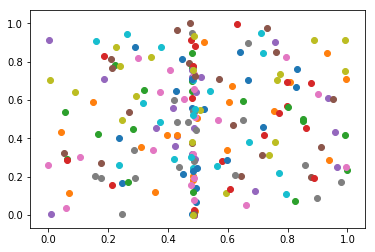

In [238]:
for soln in collection_of_optima:
    plt.scatter(soln[num_filters:], soln[:num_filters])

In [239]:
sorted_threed = np.argsort(collection_of_funs)
sorted_threed

array([13, 18, 10,  3, 16, 12, 14, 15,  0, 11,  4,  9, 17, 19,  5,  7,  6,
        1,  2,  8])

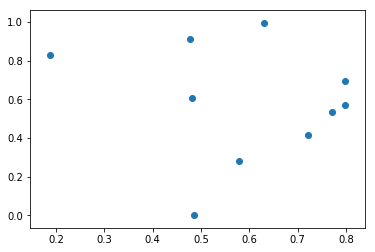

In [240]:
plt.scatter(collection_of_optima[3][num_filters:], collection_of_optima[3][:num_filters])

In [249]:
blah = actual_info - np.min(actual_info)

In [250]:
blah /= np.max(blah)

In [251]:
blah

array([ 0.69097109,  0.31930631,  0.29358061,  0.80965658,  0.51812799,
        0.4280492 ,  0.35612395,  0.39526855,  0.        ,  0.49151767,
        0.81868211,  0.65199752,  0.76108681,  1.        ,  0.73975995,
        0.73664303,  0.77650611,  0.48388807,  0.85903294,  0.46529632])

(0, 1)

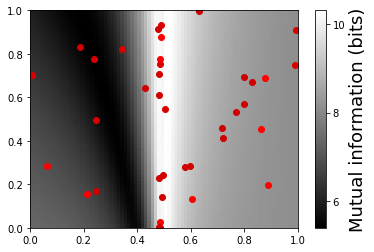

In [253]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

actual_info = -(np.array(collection_of_funs) - 20)
normalized_fun = actual_info - np.min(actual_info)
normalized_fun /= np.max(normalized_fun)
# normalized_fun = collection_of_funs - np.min(all_fun)
# normalized_fun /= np.max(collection_of_funs)
# normalized_fun -= 1.0
# normalized_fun *= -1.0
for idx in sorted_threed[:4]:
    soln_cws = collection_of_optima[idx][num_filters:]
    soln_hws = collection_of_optima[idx][:num_filters]
    #     plt.scatter(soln_cws, soln_hws, color='k', alpha=normalized_fun[idx])
    plt.scatter(soln_cws, soln_hws, c=[normalized_fun[idx], 0, 0])
    
plt.xlim(0, 1)
plt.ylim(0, 1)

In [254]:
collection_of_optima = []
collection_of_funs = []
iterations = 20
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(2 * num_filters)
    res = scipy.optimize.minimize(neg_mutual_information, random_weights, 
                                          bounds=[[0,1] for _ in range(2 * num_filters)])
    collection_of_optima.append(res.x)
    collection_of_funs.append(res.fun)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
collection_of_optima[sorted_threed[0]]

In [ ]:
collection_of_funs[sorted_threed[0]]

In [ ]:
res = scipy.optimize.minimize(neg_mutual_information, collection_of_optima[sorted_threed[0]],
                              bounds=[[0, 1] for _ in range(2 * num_filters)])

In [ ]:
res.fun

In [ ]:
res.x

In [ ]:
neg_mutual_information([0.7896293 ,  0.12085244,  0.        ,  0.48876622,  0.86031711,
        0.4848395])

In [ ]:
neg_mutual_information([0.7896293 ,  0.5085244,  0.        ,  0.48876622,  0.86031711,
        0.4848395])

In [ ]:
neg_mutual_information([0.7896293 ,  0.12085244,  0.        ,  0.48876622,  0.48831711,
        0.4848395])

In [ ]:
collection_of_optima = []
collection_of_funs = []
iterations = 5000
num_filters = 4
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(2 * num_filters)
    res = scipy.optimize.minimize(neg_mutual_information, random_weights, 
                                          bounds=[[0,1] for _ in range(2 * num_filters)])
    collection_of_optima.append(res.x)
    collection_of_funs.append(res.fun)


 18%|█▊        | 892/5000 [3:49:20<17:49:27, 15.62s/it]/home/lane/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
 23%|██▎       | 1142/5000 [4:53:40<14:11:36, 13.24s/it]

In [215]:
sorted_fourd = np.argsort(collection_of_funs)
sorted_fourd

array([13, 18, 10,  3, 16, 12, 14, 15,  0, 11,  4,  9, 17, 19,  5,  7,  6,
        1,  2,  8])

In [225]:
normalized_fun

array([ 0.43701961, -0.15684994, -0.19795609,  0.62666282,  0.16083995,
        0.01690635, -0.09802038, -0.03547266, -0.6670578 ,  0.11832029,
        0.64108438,  0.37474517,  0.54905496,  0.9308056 ,  0.51497756,
        0.50999713,  0.57369289,  0.10612924,  0.7055595 ,  0.07642216])

In [228]:
collection_of_funs

[-0.19350147661978667,
 0.91062511814578073,
 0.98704997813709738,
 -0.54608752060525489,
 0.31997375478206891,
 0.58757615886244707,
 0.80124877551283191,
 0.68495959321477784,
 1.8592073040129407,
 0.39902662386225529,
 -0.57290018460425074,
 -0.077720385512066059,
 -0.40179841510873615,
 -1.11155199264903,
 -0.33844145928034663,
 -0.32918181096673749,
 -0.44760543041518019,
 0.42169231485323166,
 -0.69277279959544558,
 0.47692394049634501]

ValueError: Invalid RGBA argument: -0.035472655418982146

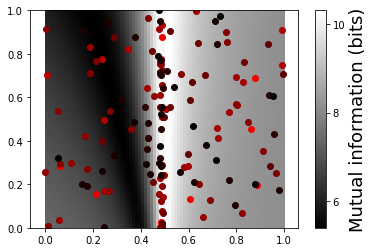

In [227]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

actual_info = -(np.array(collection_of_funs) - 20)
normalized_fun = actual_info - np.min(actual_info)
normalized_fun /= np.max(normalized_fun)
# normalized_fun = collection_of_funs - np.min(all_fun)
# normalized_fun /= np.max(collection_of_funs)
# normalized_fun -= 1.0
# normalized_fun *= -1.0
for idx in sorted_fourd[:20]:
    soln_cws = collection_of_optima[idx][num_filters:]
    soln_hws = collection_of_optima[idx][:num_filters]
    #     plt.scatter(soln_cws, soln_hws, color='k', alpha=normalized_fun[idx])
    plt.scatter(soln_cws, soln_hws, c=[normalized_fun[idx], 0, 0])
    
plt.xlim(0, 1)
plt.ylim(0, 1)

In [ ]:
hw_subpop = []
cw_subpop = []
for idx in sorted_fourd[:50]:
    hw_subpop.append(collection_of_optima[idx][:num_filters])
    cw_subpop.append(collection_of_optima[idx][num_filters:])

<Container object of 20 artists>

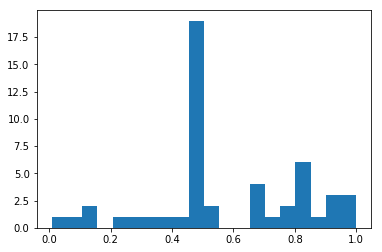

In [213]:
count, bins = np.histogram(cw_subpop, bins=20)
binwidth = np.mean(np.diff(bins))
plt.bar(bins[:-1] + binwidth/2.0, count, width=binwidth)

<Container object of 20 artists>

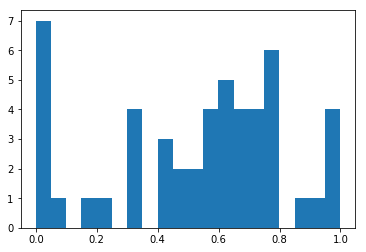

In [429]:
count, bins = np.histogram(hw_subpop, bins=20)
binwidth = np.mean(np.diff(bins))
plt.bar(bins[:-1] + binwidth/2.0, count, width=binwidth)

In [ ]:
collection_of_optima = []
collection_of_funs = []
iterations = 1000
num_filters = 5
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(2 * num_filters)
    res = scipy.optimize.minimize(neg_mutual_information, random_weights, 
                                          bounds=[[0,1] for _ in range(2 * num_filters)])
    collection_of_optima.append(res.x)
    collection_of_funs.append(res.fun)


 54%|█████▍    | 541/1000 [4:06:07<4:10:15, 32.71s/it] 

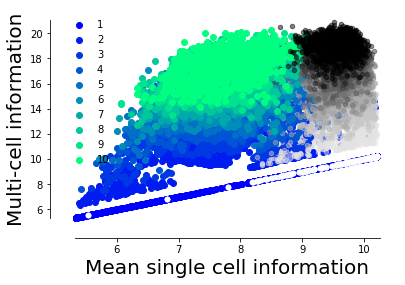

In [224]:
for i in range(1, 11):
    plt.scatter(single_cell_info[i], multi_cell_info[i], label=i, color=colors[i-1])
    plt.scatter(data_singlecell_info[i], data_multicell_info[i], color=data_colors[i-1], alpha=0.5, s=20)
# plt.scatter(single_cell_info[2], multi_cell_info[2], color='blue')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
adjust_spines(plt.gca())
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Mean single cell information', fontsize=20)
plt.ylabel('Multi-cell information', fontsize=20)

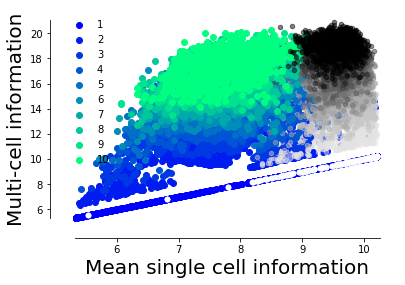

In [260]:
for i in range(1, 11):
    plt.scatter(single_cell_info[i], multi_cell_info[i], label=i, color=colors[i-1])
    plt.scatter(data_singlecell_info[i], data_multicell_info[i], color=data_colors[i-1], alpha=0.5, s=20)
# plt.scatter(single_cell_info[2], multi_cell_info[2], color='blue')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
adjust_spines(plt.gca())
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Mean single cell information', fontsize=20)
plt.ylabel('Multi-cell information', fontsize=20)

In [264]:
max(multi_cell_info[10])

20.229923623793315

In [267]:
max(single_cell_info[1])

10.213861537221714

In [268]:
single_bins = np.linspace(5, 11, 40)
multi_bins = np.linspace(5, 21, 40)
count, xedges, yedges = np.histogram2d(single_cell_info[i], multi_cell_info[i], bins=[single_bins, multi_bins])

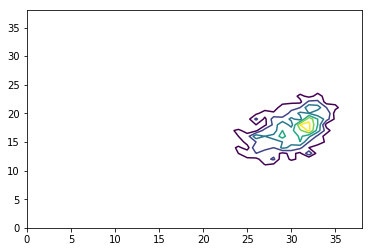

In [269]:
plt.contour(count)

### Actually, I want just a maximum envelope, not a 2d histogram contour.

In [284]:
from itertools import compress

In [347]:
def unravel_polyfit(p, x):
    unraveled = []
    degs = np.arange(len(p))[::-1]
    for xi in x:
        term = 0.0
        for pi, deg in zip(p, degs):
            term += pi * xi**deg
        unraveled.append(term)
    return unraveled

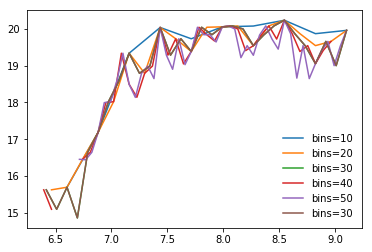

In [332]:
i = 10
bin_size = [10, 20, 30, 40, 50, 30]
for s in bin_size:
    single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
    max_multi_info = []
    for k, b in enumerate(single_bins[:-1]):
        relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
        relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
        if relevant_single_info:
            max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
        else:
            max_multi_info.append(None)
    plt.plot(single_bins[1:], max_multi_info, label=f'bins={s}')
plt.legend(frameon=False, loc='lower right')

In [333]:
smoothed_max_info = np.convolve(max_multi_info, np.ones(4)/4.0, mode='same')

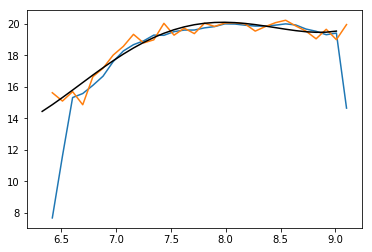

In [349]:
plt.plot(single_bins[1:], smoothed_max_info)
plt.plot(single_bins[1:], max_multi_info)

p = np.polyfit(single_bins[1:], max_multi_info, 4)
plt.plot(single_bins[:-1], unravel_polyfit(p, single_bins[:-1]), 'k')

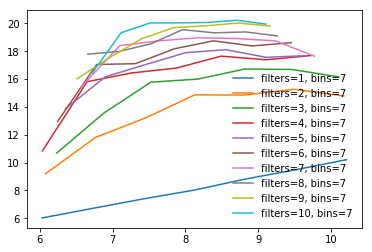

In [329]:
bin_size = [7]
for i in range(1, 11):
    for s in bin_size:
        single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
        max_multi_info = []
        for k, b in enumerate(single_bins[:-1]):
            relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
            relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
            if relevant_single_info:
                max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
            else:
                max_multi_info.append(None)
        plt.plot(single_bins[1:], max_multi_info, label=f'filters={i}, bins={s}')
    plt.legend(frameon=False, loc='lower right')

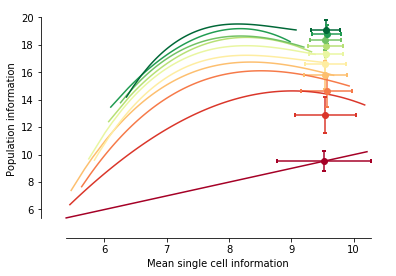

In [412]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 10))

bin_size = [100]
deg = 3
for i in range(1, 11):
    for s in bin_size:
        single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
        if i == 1:
            range_of_bins = single_bins
        max_multi_info = []
        for k, b in enumerate(single_bins[:-1]):
            relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
            relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
            if relevant_single_info:
                max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
            else:
                max_multi_info.append(None)
                
        remaining_idxs = [idx for idx in range(len(max_multi_info)) if max_multi_info[idx]]
        remaining_maxs = np.array(max_multi_info)[remaining_idxs]
        remaining_bins = single_bins[1:][remaining_idxs]
        p = np.polyfit(remaining_bins, remaining_maxs, deg)
        plt.plot(remaining_bins, unravel_polyfit(p, remaining_bins), label=f'filters={i}, bins={s}',
                 color=colors[i-1])
#         plt.plot(range_of_bins, unravel_polyfit(p, range_of_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])
        
        plt.errorbar(np.mean(data_singlecell_info[i]), np.mean(data_multicell_info[i]),
                     yerr=np.std(data_multicell_info[i]), xerr=np.std(data_singlecell_info[i]),
                     fmt='o', ecolor=colors[i-1], color=colors[i-1], capthick=2, capsize=2)
#     plt.legend(frameon=False, loc='lower right')
adjust_spines(plt.gca())
plt.xlabel('Mean single cell information')
plt.ylabel('Population information')

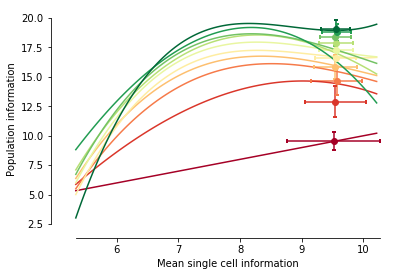

In [413]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 10))

bin_size = [100]
deg = 3
for i in range(1, 11):
    for s in bin_size:
        single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
        if i == 1:
            range_of_bins = single_bins
        max_multi_info = []
        for k, b in enumerate(single_bins[:-1]):
            relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
            relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
            if relevant_single_info:
                max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
            else:
                max_multi_info.append(None)
                
        remaining_idxs = [idx for idx in range(len(max_multi_info)) if max_multi_info[idx]]
        remaining_maxs = np.array(max_multi_info)[remaining_idxs]
        remaining_bins = single_bins[1:][remaining_idxs]
        p = np.polyfit(remaining_bins, remaining_maxs, deg)
#         plt.plot(remaining_bins, unravel_polyfit(p, remaining_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])
        plt.plot(range_of_bins, unravel_polyfit(p, range_of_bins), label=f'filters={i}, bins={s}',
                 color=colors[i-1])
        
        plt.errorbar(np.mean(data_singlecell_info[i]), np.mean(data_multicell_info[i]),
                     yerr=np.std(data_multicell_info[i]), xerr=np.std(data_singlecell_info[i]),
                     fmt='o', ecolor=colors[i-1], color=colors[i-1], capthick=2, capsize=2)
#     plt.legend(frameon=False, loc='lower right')
adjust_spines(plt.gca())
plt.xlabel('Mean single cell information')
plt.ylabel('Population information')

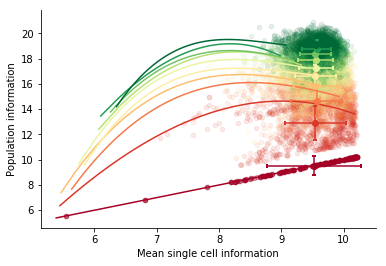

In [417]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 10))

bin_size = [100]
deg = 3
for i in range(1, 11):
    for s in bin_size:
        single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
        if i == 1:
            range_of_bins = single_bins
        max_multi_info = []
        for k, b in enumerate(single_bins[:-1]):
            relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
            relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
            if relevant_single_info:
                max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
            else:
                max_multi_info.append(None)
                
        remaining_idxs = [idx for idx in range(len(max_multi_info)) if max_multi_info[idx]]
        remaining_maxs = np.array(max_multi_info)[remaining_idxs]
        remaining_bins = single_bins[1:][remaining_idxs]
        p = np.polyfit(remaining_bins, remaining_maxs, deg)
        plt.scatter(data_singlecell_info[i], data_multicell_info[i], color=colors[i-1], alpha=0.1, s=20)
        plt.plot(remaining_bins, unravel_polyfit(p, remaining_bins), label=f'filters={i}, bins={s}',
                 color=colors[i-1])


#         plt.plot(range_of_bins, unravel_polyfit(p, range_of_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])
        
        plt.errorbar(np.mean(data_singlecell_info[i]), np.mean(data_multicell_info[i]),
                     yerr=np.std(data_multicell_info[i]), xerr=np.std(data_singlecell_info[i]),
                     fmt='o', ecolor=colors[i-1], color=colors[i-1], capthick=2, capsize=2)
#     plt.legend(frameon=False, loc='lower right')
plt.xlabel('Mean single cell information')
plt.ylabel('Population information')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


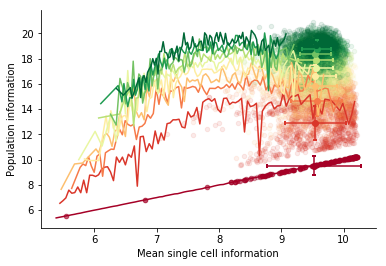

In [419]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 10))

bin_size = [100]
deg = 3
for i in range(1, 11):
    for s in bin_size:
        single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
        if i == 1:
            range_of_bins = single_bins
        max_multi_info = []
        for k, b in enumerate(single_bins[:-1]):
            relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
            relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
            if relevant_single_info:
                max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
            else:
                max_multi_info.append(None)
                
        remaining_idxs = [idx for idx in range(len(max_multi_info)) if max_multi_info[idx]]
        remaining_maxs = np.array(max_multi_info)[remaining_idxs]
        remaining_bins = single_bins[1:][remaining_idxs]
        p = np.polyfit(remaining_bins, remaining_maxs, deg)
        plt.scatter(data_singlecell_info[i], data_multicell_info[i], color=colors[i-1], alpha=0.1, s=20)
        
        plt.plot(remaining_bins, remaining_maxs, color=colors[i-1])
#         plt.plot(remaining_bins, unravel_polyfit(p, remaining_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])


#         plt.plot(range_of_bins, unravel_polyfit(p, range_of_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])
        
        plt.errorbar(np.mean(data_singlecell_info[i]), np.mean(data_multicell_info[i]),
                     yerr=np.std(data_multicell_info[i]), xerr=np.std(data_singlecell_info[i]),
                     fmt='o', ecolor=colors[i-1], color=colors[i-1], capthick=2, capsize=2)
#     plt.legend(frameon=False, loc='lower right')
plt.xlabel('Mean single cell information')
plt.ylabel('Population information')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


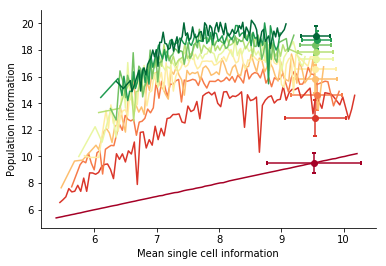

In [420]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 10))

bin_size = [100]
deg = 3
for i in range(1, 11):
    for s in bin_size:
        single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
        if i == 1:
            range_of_bins = single_bins
        max_multi_info = []
        for k, b in enumerate(single_bins[:-1]):
            relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
            relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
            if relevant_single_info:
                max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
            else:
                max_multi_info.append(None)
                
        remaining_idxs = [idx for idx in range(len(max_multi_info)) if max_multi_info[idx]]
        remaining_maxs = np.array(max_multi_info)[remaining_idxs]
        remaining_bins = single_bins[1:][remaining_idxs]
        p = np.polyfit(remaining_bins, remaining_maxs, deg)
#         plt.scatter(data_singlecell_info[i], data_multicell_info[i], color=colors[i-1], alpha=0.1, s=20)
        
        plt.plot(remaining_bins, remaining_maxs, color=colors[i-1])
#         plt.plot(remaining_bins, unravel_polyfit(p, remaining_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])


#         plt.plot(range_of_bins, unravel_polyfit(p, range_of_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])
        
        plt.errorbar(np.mean(data_singlecell_info[i]), np.mean(data_multicell_info[i]),
                     yerr=np.std(data_multicell_info[i]), xerr=np.std(data_singlecell_info[i]),
                     fmt='o', ecolor=colors[i-1], color=colors[i-1], capthick=2, capsize=2)
#     plt.legend(frameon=False, loc='lower right')
plt.xlabel('Mean single cell information')
plt.ylabel('Population information')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


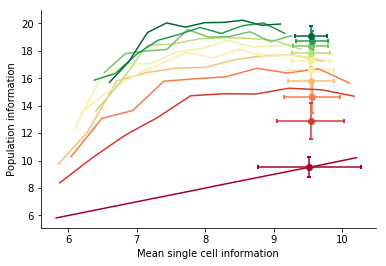

In [421]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 10))

bin_size = [10]
deg = 3
for i in range(1, 11):
    for s in bin_size:
        single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
        if i == 1:
            range_of_bins = single_bins
        max_multi_info = []
        for k, b in enumerate(single_bins[:-1]):
            relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
            relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
            if relevant_single_info:
                max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
            else:
                max_multi_info.append(None)
                
        remaining_idxs = [idx for idx in range(len(max_multi_info)) if max_multi_info[idx]]
        remaining_maxs = np.array(max_multi_info)[remaining_idxs]
        remaining_bins = single_bins[1:][remaining_idxs]
        p = np.polyfit(remaining_bins, remaining_maxs, deg)
#         plt.scatter(data_singlecell_info[i], data_multicell_info[i], color=colors[i-1], alpha=0.1, s=20)
        
        plt.plot(remaining_bins, remaining_maxs, color=colors[i-1])
#         plt.plot(remaining_bins, unravel_polyfit(p, remaining_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])


#         plt.plot(range_of_bins, unravel_polyfit(p, range_of_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])
        
        plt.errorbar(np.mean(data_singlecell_info[i]), np.mean(data_multicell_info[i]),
                     yerr=np.std(data_multicell_info[i]), xerr=np.std(data_singlecell_info[i]),
                     fmt='o', ecolor=colors[i-1], color=colors[i-1], capthick=2, capsize=2)
#     plt.legend(frameon=False, loc='lower right')
plt.xlabel('Mean single cell information')
plt.ylabel('Population information')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


# Save all information for later plot generation.

In [423]:
who

FormatStrFormatter	 MultipleLocator	 PCA	 actual_info	 adjust_spines	 all_cws	 all_fun	 all_fun_backup	 all_hws	 
all_x	 all_x_backup	 ar	 averageAmplitudeSpectrum1d	 averageAmplitudeSpectrum2d	 averageFourierTransform1d	 averageFourierTransform2d	 averagePowerSpectrum1d	 averagePowerSpectrum2d	 
ax	 b	 bin_size	 bin_width	 bins	 binwidth	 blah	 cart2pol	 cbar	 
chol_n	 chol_t	 collection_of_funs	 collection_of_optima	 collections	 colors	 compress	 constants	 convolve2d	 
corresponding_ideal	 count	 curve_fit	 cw	 cw2	 cw_res	 cw_subpop	 cws	 data_colors	 
data_multicell_info	 data_singlecell_info	 deg	 depth	 difference_of_gaussians	 exhaustive_multi_cell_info	 exhaustive_single_cell_info	 expanduser	 f	 
filter_bank	 filters	 filters_sparse	 fit_ideal	 fit_ideal_ama_only	 fit_ideal_horz_only	 fits	 flattened_num_filters	 flattened_opt_cws	 
flattened_opt_hws	 fs	 ft	 gaussian	 generate_spatial_signals	 get_amacrine_projective_fft	 get_amacrine_projective_field	 get_fft	 get_horizont

In [424]:
contour_data_dict = {
    'single_cell_info': single_cell_info,
    'multi_cell_info': multi_cell_info,
    'data_singlecell_info': data_singlecell_info,
    'data_multicell_info': data_multicell_info
}

In [426]:
import deepdish as dd

In [427]:
dd.io.save('2018_2_14_contour_plot_data.h5', contour_data_dict)

## Save information for marginal distribution of horizontal and center widths

In [455]:
collection_of_optima[0]

array([ 0.90545694,  0.63944123,  0.73717488,  0.72575242,  0.22360615,
        0.47889403,  0.78788505,  0.47677619,  0.96369461,  0.93676599])

In [456]:
hw_subpop = []
cw_subpop = []
sorted_optima = np.argsort(collection_of_funs)
for idx in sorted_optima:
    hw_subpop.append(collection_of_optima[idx][:num_filters])
    cw_subpop.append(collection_of_optima[idx][num_filters:])

<Container object of 20 artists>

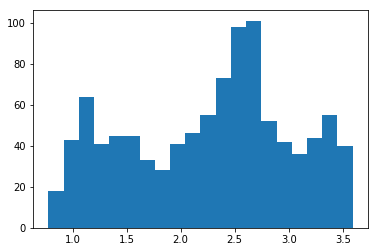

In [457]:
count, bins = np.histogram(collection_of_funs, bins=20)
bin_width = np.mean(np.diff(bins))
plt.bar(bins[:-1] - bin_width/2, count, width=bin_width)

<Container object of 20 artists>

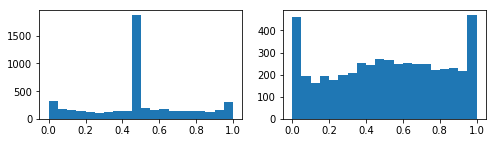

In [458]:
fig = plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
count, bins = np.histogram(cw_subpop, bins=20)
binwidth = np.mean(np.diff(bins))
plt.bar(bins[:-1] + binwidth/2.0, count, width=binwidth)

plt.subplot(1, 2, 2)
count, bins = np.histogram(hw_subpop, bins=20)
binwidth = np.mean(np.diff(bins))
plt.bar(bins[:-1] + binwidth/2.0, count, width=binwidth)

In [462]:
cw_subpop[0]

array([ 0.48451848,  0.48614178,  0.23218421,  0.57174544,  0.47608513])

In [463]:
np.stack(cw_subpop).shape

(1000, 5)

In [465]:
collection_of_info = [-(i - 20) for i in collection_of_funs]

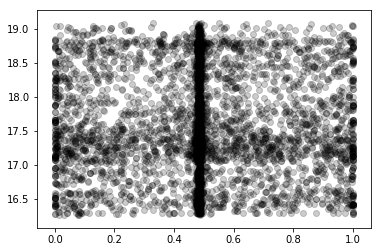

In [486]:
for idx in range(len(cw_subpop)):
    plt.scatter(cw_subpop[idx], num_filters * [collection_of_info[idx]], alpha=0.2, color='k')
    

In [478]:
hw_subpop = []
cw_subpop = []
collection_of_info = [-(i - 20) for i in collection_of_funs]
sorted_info = np.argsort(collection_of_info)[::-1]
for idx in sorted_info:
    hw_subpop.append(collection_of_optima[idx][:num_filters])
    cw_subpop.append(collection_of_optima[idx][num_filters:])

In [487]:
optima_data_dict = {
    'hws': hw_subpop,
    'cws': cw_subpop,
    'infos': collection_of_info
}

In [488]:
dd.io.save('2018_2_14_hws_cws_data.h5', optima_data_dict)

In [489]:
single_optimal_dict = {
    'sorted_optimal_cws': sorted_optimal_cws,
    'sorted_optimal_hws': sorted_optimal_hws
}

In [490]:
dd.io.save('2018_2_14_sorted_optimal_cws_hws_data.h5', single_optimal_dict)

In [491]:
spatial_signals.shape

(1000, 398)

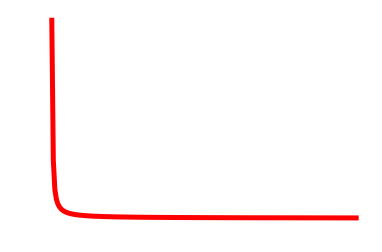

In [507]:
plt.plot(signal, linewidth=5, color='r')
ax = plt.gca()
ax.axis('off');

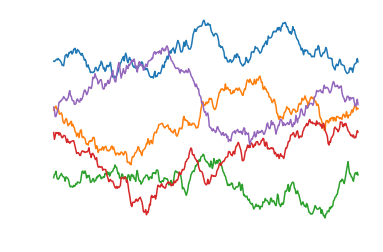

In [503]:
plt.plot(spatial_signals[:5, :].T)
ax = plt.gca()
ax.axis('off');

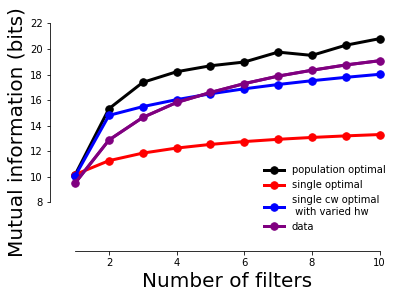

In [514]:
plt.plot(np.arange(1,11), optimal_fun_backup, 'k', linewidth=3, marker='.', markersize=15, label='population optimal')
plt.plot(np.arange(1,11), single_optimal_fun, 'r', linewidth=3, marker='.', markersize=15, label='single optimal')
plt.plot(np.arange(1,11), splitting_hws_fun, 'b', linewidth=3, marker='.', markersize=15, label='single cw optimal \n with varied hw')
# plt.plot(np.arange(1,11), splitting_cws_fun, 'c', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), mean_data_info_vs_filters, linewidth=3, color='purple', marker='.', markersize=15, label='data')
plt.errorbar(np.arange(1,11), mean_data_info_vs_filters, yerr=sem_data_info_vs_filters, linewidth=3, color='purple')
plt.xlabel('Number of filters', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
plt.legend(loc='lower right', frameon=False)
plt.ylim(5, 22)
adjust_spines(plt.gca())

In [515]:
info_comparison_dict = {
    'global_opt': optimal_fun_backup,
    'single_cell_opt': single_optimal_fun,
    'varied_hw_fixed_cw': splitting_hws_fun,
    'varied_cw_fixed_hw': splitting_cws_fun,
    'mean_data_info_vs_filters': mean_data_info_vs_filters,
    'sem_data_info_vs_filters': sem_data_info_vs_filters
}

In [516]:
dd.io.save('2018_2_14_info_comparison.h5', info_comparison_dict)

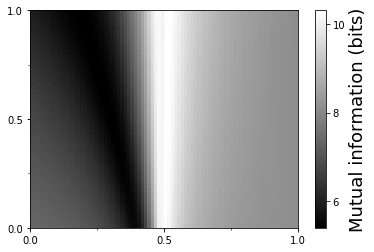

In [552]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

majorLocator = MultipleLocator(0.5)
majorLocatorx = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
majorFormatterx = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_major_locator(majorLocatorx)
ax.xaxis.set_major_formatter(majorFormatterx)
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)


plt.savefig('2018_2_17 info map.png')

In [553]:
info_map_dict = {
    'info_map': info_map,
    'all_cws': all_cws,
    'all_hws': all_hws
}

In [554]:
dd.io.save('2018_2_17_info_map.h5', info_map_dict)

In [522]:
np.unravel_index(np.argmax(info_map), info_map.shape)

(59, 41)

In [526]:
info_map.shape

(60, 80)

In [527]:
all_hws[59]

1.0

In [528]:
all_cws[41]

0.51898734177215189

In [529]:
num_filters = 1

In [534]:
res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                              bounds=[[0,1] for _ in range(2 * num_filters)])

In [535]:
res.x

array([ 0.64506208,  0.5121445 ])

In [549]:
num_filters = 2
res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                              bounds=[[0,1] for _ in range(2 * num_filters)])

In [550]:
res.x

array([ 0.93066594,  0.82759267,  0.56116449,  0.46665413])

In [555]:
bkup_optimal_filters = optimal_filters
bkup_optimal_fun = optimal_fun

In [ ]:
optimal_filters = []
optimal_fun = []
for num_filters in tqdm(range(1, 11)):
    lowest_fun = 100
    all_x = []
    all_fun = []
    iterations = 200
    for i in range(iterations):
        res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                      bounds=[[0,1] for _ in range(2 * num_filters)])
        if res.fun < lowest_fun:
            lowest_fun = res.fun
            opt_x = res.x
        all_x.append(res.x)
        all_fun.append(res.fun)
    optimal_filters.append(opt_x)
    optimal_fun.append(-(lowest_fun - 20))

 80%|████████  | 8/10 [13:36:45<5:29:34, 9887.14s/it]